#### Colab Link
    https://colab.research.google.com/drive/1aeh7TsszRJr6e1z-7ItukXZD_cOPqiLU?usp=sharing

#### Reference

    1. Automatic Chemical Design Using a Data-Driven Continuous Representation of Molecules, 2015 ( https://pubs.acs.org/doi/full/10.1021/acscentsci.7b00572 )
        ✔ SMILES VAE는 분자를 연속적이고 차별화 가능한 latent space에 매핑하며, 특정 속성(logP, QED, SAS, 생체 활성 등)에 최적화할 수 있음.

    2. Self-Referencing Embedded Strings (SELFIES): A 100% robust molecular string representation, 2020 ( https://iopscience.iop.org/article/10.1088/2632-2153/aba947 )
        ✔ language model로 분자를 생성할 때, invalid한 분자를 생성할 가능성이 있는 SMILES 표기와 달리, SELIFES 표기를 사용하여 100% valid한 분자 생성을 하도록 함.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Tue Aug 22 04:34:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb
!pip install rdkit
!pip install selfies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=978e146963093f2fa3033d4ab656a035ddfb499b28d4eb68d869e3c428992f23
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 47.8 MB/s eta 0:00:00


In [ ]:
import argparse
import sys
import yaml
import json
import os
import joblib
import networkx as nx
from tqdm import tqdm
from datetime import datetime
import time
import random
import copy
from collections import defaultdict
import pickle as pkl
import re
import spacy
import codecs
import collections.abc
collections.Mapping = collections.abc.Mapping

from prettytable import PrettyTable
import selfies
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw
import rdkit.Chem.AllChem as AllChem
from PIL import Image
from IPython.core.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

os.environ['TORCH'] = torch.__version__
print(f'Torch ver. : {torch.__version__}')

Torch ver. : 2.0.1+cu118


In [ ]:
ENTITY = 'rossi22'
TRAIN_PROJECT = 'TRANS_VAE_SELFIES_TRAIN'
SWEEP_PROJECT = 'TRANS_VAE_SELFIES_SWEEP'

DEFAULT_PARAMS = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'batch_size': 128,
    'learning_rate': 0.0002,
    'epochs': 500,
    'period':5,

    'embed_dim': 32,
    'latent_dim': 128,
    'hidden_dim': 64,
    'enc_layers': 4,
    'dec_layers': 4,
    'enc_heads': 8,
    'dec_heads': 8,
    'enc_pos_dim': 256,
    'dec_pos_dim': 256,
    'enc_dropout': 0.1,
    'dec_dropout': 0.1,
    'pad_idx': 0,
    'clip': 0.01,

    'use_scheduler': True,
    'schd_factor': 0.5,
    'schd_patience': 10,
    'schd_min_lr': 5e-6,
}

In [ ]:
def load_smiles(file_name, num_mol):
    file_pkl = pkl.load(open(file_name, 'rb'))
    num_mol = min(len(file_pkl), num_mol)
    smi_list = []
    selfies_list = []
    for i in tqdm(range(num_mol), desc='Reading Data'):
        smi = file_pkl[i].strip()
        smi_list.append(smi)
        selfies_list.append(selfies.encoder(smi))

    return smi_list, selfies_list

In [ ]:
_, selfies_list = load_smiles('/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/ZINC_smi.pkl', int(3e5))
_, selfies_list2 = load_smiles('/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/ZINC_smi2.pkl', int(3e5))
selfies_list = list(set(selfies_list+selfies_list2))
print(len(selfies_list))

Reading Data: 100%|██████████| 251637/251637 [01:26<00:00, 2899.70it/s]


350867


In [ ]:
def dict_tokens(data) :
    tokens = {'<pad>': 0, '<sos>': 1, '<eos>': 2, }
    max_len = 0
    for word in data :
        max_len = max(max_len, selfies.len_selfies(word))

    selfies_token_list = selfies.get_alphabet_from_selfies(data)
    selfies_tokens = {key:i+3 for i, key in enumerate(selfies_token_list)}
    tokens.update(selfies_tokens)
    selfies_r_tokens = {val:key for (key, val) in tokens.items()}

    return max_len+2, tokens, selfies_r_tokens

DEFAULT_PARAMS['selfies_max_len'], DEFAULT_PARAMS['selfies_tokens'], DEFAULT_PARAMS['selfies_reverse_tokens'] = dict_tokens(selfies_list)

In [ ]:
def embedding_data(data, max_len=DEFAULT_PARAMS['selfies_max_len'], dict_tokens=DEFAULT_PARAMS['selfies_tokens']) :
    emb_data = torch.zeros((len(data), max_len))

    for idx1, word in tqdm(enumerate(data)) :
        emb_data[idx1][0] = dict_tokens['<sos>']
        idx2 = 1
        for tok in selfies.split_selfies(word) :
            if tok != '.' :
                emb_data[idx1][idx2] = dict_tokens[tok]
                idx2 +=1
        emb_data[idx1][idx2] = dict_tokens['<eos>']

    emb_data = emb_data.type(torch.LongTensor)
    return emb_data

embedded_selfies = embedding_data(selfies_list)

print(selfies_list[0])
print(embedded_selfies[0])

350867it [01:25, 4095.33it/s]


[C][C][=C][C][=C][Branch1][#C][C][=Branch1][C][=O][O][C][C][C][N][C][Branch1][C][N][=O][C][=C][Ring1][S][C]
tensor([ 1, 15, 15, 37, 15, 37,  3, 35, 15, 16, 15, 34, 29, 15, 15, 15, 41, 15,
         3, 15, 41, 34, 15, 37, 38, 36, 15,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0])


In [ ]:
train_size = int(len(selfies_list) * 9.5 // 10)
val_size = (len(selfies_list)-train_size)//2

def set_seed(seed_value):

    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    np.random.seed(seed_value)
    random.seed(seed_value)

set_seed(52)
random.shuffle(embedded_selfies)

TRAIN_SET, VAL_SET, TEST_SET = embedded_selfies[:train_size], embedded_selfies[train_size:train_size+val_size], embedded_selfies[train_size+val_size:]
print(len(TRAIN_SET), len(VAL_SET), len(TEST_SET))

333323 8772 8772


In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # [1], [2] Attention Energy 계산, scaling
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # [3] 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # [4] 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)
        # attention: [batch_size, n_heads, query_len, key_len]

        # [5] attention과 Value의 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)
        # x: [batch_size, n_heads, query_len, head_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        # x: [batch_size, query_len, n_heads, head_dim]
        x = x.view(batch_size, -1, self.hidden_dim)
        # x: [batch_size, query_len, hidden_dim]
        x = self.fc_o(x)
        # x: [batch_size, query_len, hidden_dim]
        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pos_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pos_dim)
        self.fc_2 = nn.Linear(pos_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        # x: [batch_size, seq_len, hidden_dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        # x: [batch_size, seq_len, pos_dim]
        x = self.fc_2(x)
        # x: [batch_size, seq_len, hidden_dim]
        return x

class GatedSkipConnection(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        # z : 0 ~ 1 사이의 값
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out

    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pos_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pos_dim, dropout_ratio)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.gsc = GatedSkipConnection(hidden_dim, hidden_dim)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):
        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)
        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(self.gsc(src, _src))
        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)
        # dropout, residual and layer norm
        src = self.ff_layer_norm(self.gsc(src, _src))
        # src: [batch_size, src_len, hidden_dim]

        return src

class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, latent_dim,  n_layers, n_heads, pos_dim, dropout_ratio, max_len, device):
        super().__init__()

        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, embed_dim)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        self.initial_linear = nn.Linear(embed_dim, hidden_dim)
        self.en_layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pos_dim, dropout_ratio, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([embed_dim])).to(device)

        self.relu = nn.ReLU()
        self.mean = nn.Linear(max_len * hidden_dim, latent_dim)
        self.log_var = nn.Linear(max_len * hidden_dim, latent_dim)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # src: [batch_size, src_len, embed_dim]
        src = self.initial_linear(src)
        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.en_layers:
            src = layer(src, src_mask)

        encoded = src.contiguous().view(src.size(0), -1)
        # encoded: [batch_size, src_len * hidden_dim]

        mean = self.relu(self.mean(encoded))
        log_var = self.relu(self.log_var(encoded))
        # mean, log_var: [batch_size, latent_dim]

        return mean, log_var

class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pos_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pos_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)
        self.gsc = GatedSkipConnection(hidden_dim, hidden_dim)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, 1, src_len-1, src_len-1]
        # src_mask: [batch_size, 1, 1, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(self.gsc(trg, _trg))
        # trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(self.gsc(trg, _trg))

        # trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, latent_dim, n_layers, n_heads, pos_dim, dropout_ratio, max_len, device):
        super().__init__()

        self.device = device
        self.hidden_dim = hidden_dim
        self.max_len = max_len
        self.latent_layer = nn.Linear(latent_dim, max_len*hidden_dim)
        self.relu = nn.ReLU()

        self.tok_embedding = nn.Embedding(output_dim, embed_dim)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        self.initial_linear = nn.Linear(embed_dim, hidden_dim)
        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pos_dim, dropout_ratio, device) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, z, trg_mask, src_mask):

        # z: [batch_size, latent_dim]
        # trg: [batch_size, src_len-1]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, src_len-1]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        z = self.relu(self.latent_layer(z))
        enc_src = z.view(batch_size, self.max_len, self.hidden_dim)

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # trg: [batch_size, trg_len, embed_dim]

        trg = self.initial_linear(trg)

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)
        # output: [batch_size, trg_len, output_dim]

        return output, attention

class TransformerVAE(nn.Module):
    def __init__(self, args) :
        super().__init__()

        self.encoder = Encoder(len(args['selfies_tokens']), args['embed_dim'], args['hidden_dim'], args['latent_dim'], args['enc_layers'], args['enc_heads'], args['enc_pos_dim'], args['enc_dropout'], args['selfies_max_len'], args['device'])
        self.decoder = Decoder(len(args['selfies_tokens']), args['embed_dim'], args['hidden_dim'], args['latent_dim'], args['dec_layers'], args['dec_heads'], args['dec_pos_dim'], args['dec_dropout'], args['selfies_max_len'], args['device'])
        self.pad_idx = args['pad_idx']
        self.device = device
        self.latent_dim = args['latent_dim']
        self.recon_criterion = nn.CrossEntropyLoss(ignore_index=args['pad_idx'])

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0(False)으로 설정
    def make_src_mask(self, src):
        # src: [batch_size, src_len]
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask: [batch_size, 1, 1, src_len]
        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):
        # trg: [batch_size, src_len-1]

        trg_pad_mask = (trg != self.pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask: [batch_size, 1, 1, src_len-1]

        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        # trg_sub_mask: [src_len-1, src_len-1]
        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask: [batch_size, 1, src_len-1, src_len-1]
        return trg_mask

    def reparameterize(self, mean, log_var) :
        eps = torch.randn(mean.size(0), self.latent_dim).to(device)
        z = eps * torch.exp(log_var * .5) + mean
        return z

    def vae_loss(self, x, mean, log_var, z, x_hat) :
        x_hat = x_hat.contiguous().view(-1, x_hat.shape[-1])
        x = x.contiguous().view(-1)

        recon_loss = self.recon_criterion(x_hat, x)
        kl_loss = 0.5 * torch.sum(torch.square(mean) + torch.exp(log_var) - log_var -1)

        return recon_loss + kl_loss

    def forward(self, src):
        dec_src = src[:, 1:]
        trg = src[:, :-1]
        # src: [batch_size, len_src]
        # dec_src: [batch_size, len_src-1]
        # trg: [batch_size, len_src-1]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        # src_mask: [batch_size, 1, 1, len_src]
        # trg_mask: [batch_size, 1, len_src-1, len_src-1]

        mean, log_var = self.encoder(src, src_mask)
        z = self.reparameterize(mean, log_var)
        # z: [batch_size, latent_dim]
        # enc_src: [batch_size, len_src, hidden_dim]

        src_hat, attention = self.decoder(trg, z, trg_mask, src_mask)
        loss = self.vae_loss(dec_src, mean, log_var, z, src_hat)
        # output: [batch_size, len_src-1, output_dim]
        # attention: [batch_size, n_heads, len_src-1, len_src]
        return src_hat, attention, loss

In [ ]:
def run_train(model, train_iterator, val_iterator, optimizer, clip, device):
    epoch_train_loss = 0
    epoch_val_loss = 0

    # train
    model.train()

    for i, tokens in enumerate(train_iterator):
        tokens = tokens.to(device)
        optimizer.zero_grad()
        _, _, train_loss = model(tokens)

        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_train_loss += train_loss.item()

    # validation
    model.eval()

    with torch.no_grad() :
        for i, tokens in enumerate(val_iterator) :
            tokens = tokens.to(device)

            _, _, val_loss = model(tokens)
            epoch_val_loss += val_loss.item()

    epoch_train_loss /= len(train_iterator)
    epoch_val_loss /= len(val_iterator)

    return epoch_train_loss, epoch_val_loss

In [ ]:
OPT_PARAMS = copy.copy(DEFAULT_PARAMS)

In [ ]:
# 하이퍼파라미터 최적화를 위해 wandb sweep을 설정 및 실행하는 클래스
class SweepSetting() :
    def __init__(self, sweep_setting, name) :
        wandb_api = wandb.Api()
        sweep_setting['name'] = name

        self.device = DEFAULT_PARAMS['device']
        self.sweep_id = wandb.sweep(sweep=sweep_setting, project=SWEEP_PROJECT)
        self.count = sweep_setting['count']
        self.sweep_output = None
        self.best_run = None

    def copy_params(self, run) :
        params = copy.copy(OPT_PARAMS)
        args = run.config

        def load_config(elem) :
            if args.get(elem) :
                return args[elem]
            else :
                return params[elem]

        return params

    # hyperparameter를 sweep 설정에 따라 변경해가며 최적화된 hyperparameter value를 산출하는 메소드
    def sweep_callback(self) :
        with wandb.init() as run :
            params = self.copy_params(run)
            print(f'params : {params}')

            train_dataloader = torch.utils.data.DataLoader(TRAIN_SET, batch_size=params['batch_size'], shuffle=False, drop_last = True)
            val_dataloader = torch.utils.data.DataLoader(VAL_SET, batch_size=params['batch_size'], shuffle=False, drop_last = True)

            model = TransformerVAE(params).to(self.device)

            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
            epochs = params['epochs']

            for epoch in tqdm(range(1, epochs + 1)) :
                epoch_train_loss, epoch_val_loss = run_train(model, train_dataloader, val_dataloader, optimizer, params['clip'], self.device)
                wandb.log({'epoch': epoch, 'epoch_train_loss': epoch_train_loss, 'epoch_val_loss': epoch_val_loss})

        wandb.finish()
        print('='*150)

    # 스윕 실행
    def start_agent(self) :
        wandb.agent(self.sweep_id, project=SWEEP_PROJECT, function=self.sweep_callback, count=self.count)

    # 스윕 결과로부터 최적화된 hyperparameter 반환
    def get_best_params(self) :
        wandb_api = wandb.Api()
        self.sweep_output = wandb_api.sweep(f'{ENTITY}/{SWEEP_PROJECT}/{self.sweep_id}')
        self.best_run = sorted(self.sweep_output.runs, key=lambda r: r.summary.get('epoch_val_loss', float('inf')))[0]

        temp = json.loads(self.best_run.json_config)
        best_params = copy.copy(OPT_PARAMS)

        for key, value in temp.items() :
                best_params[key] = temp[key]['value']

        return best_params

In [ ]:
# 모델의 학습, 테스트, 파라미터 계산 및 저장, wandb artifact로부터 모델 불러오기를 수행하는 클래스
class Trial() :
    def __init__(self, model, optimizer, params, use_wb, scheduler=None) :
        self.device = OPT_PARAMS['device']
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.params = params
        self.use_wb = use_wb
        self.clip = OPT_PARAMS['clip']
        self.model_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/'
        self.start_epoch = 1
        self.run = None
        self.report = None

        self.model.apply(self.initialize_weights)

    # Wandb 세션 초기화
    def wandb_init(self) :
        if self.use_wb :
            wandb.finish()

            wandb_api = wandb.Api()
            api_runs = wandb_api.runs(f'{ENTITY}/{TRAIN_PROJECT}')
            run = wandb.init(project=TRAIN_PROJECT, name=f"trial_{len(api_runs)+1}")
            report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{run.id}')

            self.run, self.report = run, report

    def initialize_weights(self, m):
        if hasattr(m, 'weight') and m.weight is not None and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)

    # 입력한 run_id에 해당하는 실행 정보를 불러옴
    def wandb_load_run(self, run_id) :
        if self.use_wb :
            wandb_api = wandb.Api()
            run = wandb.init(project=TRAIN_PROJECT, id=run_id, resume=True)
            report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{run.id}')

            self.run, self.report = run, report

    # 모델의 학습, 최적화된 모델을 wandb 서버에 저장하는 메소드
    def train(self, train_dataloader, val_dataloader, start_epoch=1) :
        epochs = self.params['epochs']
        period = self.params['period']
        train_loss_list = []
        val_loss_list = []

        today = datetime.now()
        date_str = today.strftime('%y%m%d')
        best_model_name = f'{TRAIN_PROJECT}_best_model_{date_str}.pth'

        # 가장 낮은 validation loss값을 기준으로 모델의 파라미터 저장
        best_val_loss = float('inf')

        for epoch in tqdm(range(start_epoch, epochs + 1)) :
            epoch_train_loss, epoch_val_loss = run_train(self.model, train_dataloader, val_dataloader, self.optimizer, self.clip, self.device )

            train_loss_list.append(epoch_train_loss)
            val_loss_list.append(epoch_val_loss)

            if self.params['use_scheduler'] and self.scheduler != None :
                self.scheduler.step(epoch_val_loss)

            if self.use_wb :
                self.run.log({'epoch': epoch, 'epoch_train_loss': epoch_train_loss, 'epoch_val_loss': epoch_val_loss})

                if epoch_val_loss < best_val_loss :
                    best_val_loss = epoch_val_loss
                    torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch_val_loss': epoch_val_loss,
                    }, f'{self.model_path}{best_model_name}')

            if epoch == 1 or epoch % period == 0 :
                print(f'{"epoch":>12} {epoch:<4} / {epochs:>4}  {"[epoch_train_loss :":>15} {epoch_train_loss:.5f}] {"[epoch_val_loss :":>12} {epoch_val_loss:.5f}] {"[lr :":>8} {self.optimizer.param_groups[0]["lr"]:.8f}]')

        return train_loss_list, val_loss_list

    # 학습된 모델을 테스트하는 메소드
    def test(self, test_dataloader) :

        self.model.eval()
        with torch.no_grad() :
            tokens = next(iter(test_dataloader))
            tokens = tokens.to(self.device)

            _, _, test_loss = self.model(tokens)
            test_loss = test_loss.detach().cpu().numpy()

        if self.use_wb :
            wandb_api = wandb.Api()
            self.run.summary['test_loss'] = test_loss
            self.report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{self.run.id}')

        return test_loss

    def count_parameters(self) :
        table = PrettyTable(['Modules', 'Parameters'])
        total_params = 0

        for name, parameter in self.model.named_parameters() :
            if not parameter.requires_grad :
                continue

            param = parameter.numel()
            table.add_row([name, param])
            total_params += param

        print(table)
        print(f'Total Trainable Params : {total_params}')
        return total_params

    def upload(self, best_model_name) :

        if self.use_wb :
            wandb_api = wandb.Api()
            self.report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{self.run.id}')

            artifact = wandb.Artifact(best_model_name, type='model')
            artifact.add_file(f'{self.model_path}{best_model_name}')

            self.run.log_artifact(artifact)

    # wandb에 저장한 모델의 파라미터를 불러오는 메소드.
    def load_model(self, file_name, from_wandb=False) :
        if from_wandb :
            model_name = (file_name.split('/')[-1]).split(':')[0]

            artifact = self.run.use_artifact(file_name, type='model')
            artifact_dir = artifact.download()
            artifact_state_dict = torch.load(os.path.join(artifact_dir, model_name))

        else :
            artifact_state_dict = torch.load(f'{self.model_path}{file_name}')

        self.model = TransformerVAE(self.params)
        self.model.load_state_dict(artifact_state_dict['model_state_dict'])
        self.model.to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params['learning_rate'])
        self.optimizer.load_state_dict(artifact_state_dict['optimizer_state_dict'])

        self.start_epoch = artifact_state_dict['epoch']

    def gen_mols(self, target_smiles, noise_size) :
        max_len = self.params['selfies_max_len']
        selfies_tokens = self.params['selfies_tokens']
        selfies_reverse_tokens = self.params['selfies_reverse_tokens']
        latent_dim = self.params['latent_dim']

        gen_smiles = torch.zeros((1, max_len))
        gen_smiles[0][0] = selfies_tokens['<sos>']

        for idx, tok in enumerate(selfies.split_selfies(selfies.encoder(target_smiles)), 1) :
            gen_smiles[0][idx] = selfies_tokens[tok]
        gen_smiles[0][idx+1] = selfies_tokens['<eos>']

        gen_src = gen_smiles.type(torch.LongTensor)

        def gen(noise) :
            src_mask = self.model.make_src_mask(gen_src).to(device)
            trg_index = [selfies_tokens['<sos>']]

            for i in range(max_len) :
                trg_tensor = torch.LongTensor(trg_index).unsqueeze(0).to(device)
                trg_mask = self.model.make_trg_mask(trg_tensor).to(device)
                with torch.no_grad() :
                    output, attention = self.model.decoder(trg_tensor, noise, trg_mask, src_mask)
                pred_token = output.argmax(2)[:, -1].item()
                trg_index.append(pred_token)

                if pred_token == selfies_tokens['<eos>'] :
                    break

            result_smiles = ''.join([selfies_reverse_tokens[tok] for tok in trg_index][1:-1])
            return selfies.decoder(result_smiles)


        with torch.no_grad() :
            noise = torch.randn(noise_size, latent_dim).to(device)

        gen_smiles = set()

        for n in range(noise_size) :
            result_smiles = gen(noise[n])

            gen_mol = Chem.MolFromSmiles(result_smiles)
            if gen_mol != None :
                gen_smiles.add(result_smiles)

        return list(gen_smiles)

# Sweep

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/jsons/'
login_file_name = 'wandb.json'
login_file_path = os.path.join(dir_path, login_file_name)

with open(login_file_path, 'r') as f :
    json_wandb = json.load(f)

wandb.login(key=json_wandb['key'])
time.sleep(5)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
yaml_files = sorted(os.listdir(os.path.join(dir_path, 'TRANS_VAE_SELFIES')))
list_sweep = []
print(yaml_files)

['1_learning_rate.yaml']


In [ ]:
for idx, yf in enumerate(yaml_files, 1) :
    print(f'\n{"="*70} Condition {idx} {"="*70}\n')
    print('-'*150)
    sweep_setting_name = yf
    sweep_setting_path = os.path.join(dir_path, 'TRANS_VAE_SELFIES', sweep_setting_name)

    with open(sweep_setting_path, 'r') as f :
        sweep_setting = yaml.load(f, Loader=yaml.FullLoader)
        current_sweep = SweepSetting(sweep_setting, sweep_setting_name.split('.')[0])
        current_sweep.start_agent()

        OPT_PARAMS = current_sweep.get_best_params()
        print(f'\nbest hyperparameters : {OPT_PARAMS}\n')
        print('-'*150)

        list_sweep.append(current_sweep)


====================================================================== Condition 1 ======================================================================

------------------------------------------------------------------------------------------------------------------------------------------------------


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('count' was unexpected)


Create sweep with ID: oqn7k096
Sweep URL: https://wandb.ai/rossi22/TRANS_VAE_SELFIES_SWEEP/sweeps/oqn7k096


wandb: Agent Starting Run: 4f47uz4g with config:
wandb: 	learning_rate: 0.0001
wandb: Currently logged in as: rossi22. Use `wandb login --relogin` to force relogin


params : {'device': device(type='cpu'), 'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 20, 'embed_dim': 32, 'latent_dim': 64, 'hidden_dim': 32, 'enc_layers': 4, 'dec_layers': 4, 'enc_heads': 8, 'dec_heads': 8, 'enc_pos_dim': 256, 'dec_pos_dim': 256, 'enc_dropout': 0.1, 'dec_dropout': 0.1, 'pad_idx': 0, 'clip': 0.01, 'use_scheduler': False, 'selfies_max_len': 34, 'selfies_tokens': {'<pad>': 0, '<sos>': 1, '<eos>': 2, '[Cl]': 3, '[NH1]': 4, '[#C]': 5, '[O]': 6, '[=O]': 7, '[Br]': 8, '[#Branch2]': 9, '[=Ring1]': 10, '[Ring1]': 11, '[S]': 12, '[=Branch2]': 13, '[=Branch1]': 14, '[Ring2]': 15, '[Branch1]': 16, '[C]': 17, '[Branch2]': 18, '[N]': 19, '[=Ring2]': 20, '[P]': 21, '[#Branch1]': 22, '[=S]': 23, '[=C]': 24, '[=N]': 25, '[#N]': 26, '[F]': 27}, 'selfies_reverse_tokens': {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '[Cl]', 4: '[NH1]', 5: '[#C]', 6: '[O]', 7: '[=O]', 8: '[Br]', 9: '[#Branch2]', 10: '[=Ring1]', 11: '[Ring1]', 12: '[S]', 13: '[=Branch2]', 14: '[=Branch1]', 15: '[Ring2]

100%|██████████| 20/20 [16:53<00:00, 50.66s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,20
epoch_train_loss,1.37593
epoch_val_loss,1.29773


wandb: Agent Starting Run: fxe8a6r9 with config:
wandb: 	learning_rate: 0.0002


params : {'device': device(type='cpu'), 'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 20, 'embed_dim': 32, 'latent_dim': 64, 'hidden_dim': 32, 'enc_layers': 4, 'dec_layers': 4, 'enc_heads': 8, 'dec_heads': 8, 'enc_pos_dim': 256, 'dec_pos_dim': 256, 'enc_dropout': 0.1, 'dec_dropout': 0.1, 'pad_idx': 0, 'clip': 0.01, 'use_scheduler': False, 'selfies_max_len': 34, 'selfies_tokens': {'<pad>': 0, '<sos>': 1, '<eos>': 2, '[Cl]': 3, '[NH1]': 4, '[#C]': 5, '[O]': 6, '[=O]': 7, '[Br]': 8, '[#Branch2]': 9, '[=Ring1]': 10, '[Ring1]': 11, '[S]': 12, '[=Branch2]': 13, '[=Branch1]': 14, '[Ring2]': 15, '[Branch1]': 16, '[C]': 17, '[Branch2]': 18, '[N]': 19, '[=Ring2]': 20, '[P]': 21, '[#Branch1]': 22, '[=S]': 23, '[=C]': 24, '[=N]': 25, '[#N]': 26, '[F]': 27}, 'selfies_reverse_tokens': {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '[Cl]', 4: '[NH1]', 5: '[#C]', 6: '[O]', 7: '[=O]', 8: '[Br]', 9: '[#Branch2]', 10: '[=Ring1]', 11: '[Ring1]', 12: '[S]', 13: '[=Branch2]', 14: '[=Branch1]', 15: '[Ring2]

100%|██████████| 20/20 [16:51<00:00, 50.57s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,20
epoch_train_loss,1.3714
epoch_val_loss,1.29793


wandb: Agent Starting Run: lmijgnx8 with config:
wandb: 	learning_rate: 0.0005


params : {'device': device(type='cpu'), 'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 20, 'embed_dim': 32, 'latent_dim': 64, 'hidden_dim': 32, 'enc_layers': 4, 'dec_layers': 4, 'enc_heads': 8, 'dec_heads': 8, 'enc_pos_dim': 256, 'dec_pos_dim': 256, 'enc_dropout': 0.1, 'dec_dropout': 0.1, 'pad_idx': 0, 'clip': 0.01, 'use_scheduler': False, 'selfies_max_len': 34, 'selfies_tokens': {'<pad>': 0, '<sos>': 1, '<eos>': 2, '[Cl]': 3, '[NH1]': 4, '[#C]': 5, '[O]': 6, '[=O]': 7, '[Br]': 8, '[#Branch2]': 9, '[=Ring1]': 10, '[Ring1]': 11, '[S]': 12, '[=Branch2]': 13, '[=Branch1]': 14, '[Ring2]': 15, '[Branch1]': 16, '[C]': 17, '[Branch2]': 18, '[N]': 19, '[=Ring2]': 20, '[P]': 21, '[#Branch1]': 22, '[=S]': 23, '[=C]': 24, '[=N]': 25, '[#N]': 26, '[F]': 27}, 'selfies_reverse_tokens': {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '[Cl]', 4: '[NH1]', 5: '[#C]', 6: '[O]', 7: '[=O]', 8: '[Br]', 9: '[#Branch2]', 10: '[=Ring1]', 11: '[Ring1]', 12: '[S]', 13: '[=Branch2]', 14: '[=Branch1]', 15: '[Ring2]

100%|██████████| 20/20 [16:49<00:00, 50.47s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,20
epoch_train_loss,1.38946
epoch_val_loss,1.31963


wandb: Agent Starting Run: 8cagysgo with config:
wandb: 	learning_rate: 0.001


params : {'device': device(type='cpu'), 'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 20, 'embed_dim': 32, 'latent_dim': 64, 'hidden_dim': 32, 'enc_layers': 4, 'dec_layers': 4, 'enc_heads': 8, 'dec_heads': 8, 'enc_pos_dim': 256, 'dec_pos_dim': 256, 'enc_dropout': 0.1, 'dec_dropout': 0.1, 'pad_idx': 0, 'clip': 0.01, 'use_scheduler': False, 'selfies_max_len': 34, 'selfies_tokens': {'<pad>': 0, '<sos>': 1, '<eos>': 2, '[Cl]': 3, '[NH1]': 4, '[#C]': 5, '[O]': 6, '[=O]': 7, '[Br]': 8, '[#Branch2]': 9, '[=Ring1]': 10, '[Ring1]': 11, '[S]': 12, '[=Branch2]': 13, '[=Branch1]': 14, '[Ring2]': 15, '[Branch1]': 16, '[C]': 17, '[Branch2]': 18, '[N]': 19, '[=Ring2]': 20, '[P]': 21, '[#Branch1]': 22, '[=S]': 23, '[=C]': 24, '[=N]': 25, '[#N]': 26, '[F]': 27}, 'selfies_reverse_tokens': {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '[Cl]', 4: '[NH1]', 5: '[#C]', 6: '[O]', 7: '[=O]', 8: '[Br]', 9: '[#Branch2]', 10: '[=Ring1]', 11: '[Ring1]', 12: '[S]', 13: '[=Branch2]', 14: '[=Branch1]', 15: '[Ring2]

100%|██████████| 20/20 [16:53<00:00, 50.68s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,20
epoch_train_loss,1.38368
epoch_val_loss,1.31123


wandb: Agent Starting Run: 3bni8doe with config:
wandb: 	learning_rate: 0.002


params : {'device': device(type='cpu'), 'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 20, 'embed_dim': 32, 'latent_dim': 64, 'hidden_dim': 32, 'enc_layers': 4, 'dec_layers': 4, 'enc_heads': 8, 'dec_heads': 8, 'enc_pos_dim': 256, 'dec_pos_dim': 256, 'enc_dropout': 0.1, 'dec_dropout': 0.1, 'pad_idx': 0, 'clip': 0.01, 'use_scheduler': False, 'selfies_max_len': 34, 'selfies_tokens': {'<pad>': 0, '<sos>': 1, '<eos>': 2, '[Cl]': 3, '[NH1]': 4, '[#C]': 5, '[O]': 6, '[=O]': 7, '[Br]': 8, '[#Branch2]': 9, '[=Ring1]': 10, '[Ring1]': 11, '[S]': 12, '[=Branch2]': 13, '[=Branch1]': 14, '[Ring2]': 15, '[Branch1]': 16, '[C]': 17, '[Branch2]': 18, '[N]': 19, '[=Ring2]': 20, '[P]': 21, '[#Branch1]': 22, '[=S]': 23, '[=C]': 24, '[=N]': 25, '[#N]': 26, '[F]': 27}, 'selfies_reverse_tokens': {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '[Cl]', 4: '[NH1]', 5: '[#C]', 6: '[O]', 7: '[=O]', 8: '[Br]', 9: '[#Branch2]', 10: '[=Ring1]', 11: '[Ring1]', 12: '[S]', 13: '[=Branch2]', 14: '[=Branch1]', 15: '[Ring2]

100%|██████████| 20/20 [17:01<00:00, 51.09s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,20
epoch_train_loss,1.38107
epoch_val_loss,1.30236


wandb: Agent Starting Run: 7rf77sg5 with config:
wandb: 	learning_rate: 0.005


params : {'device': device(type='cpu'), 'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 20, 'embed_dim': 32, 'latent_dim': 64, 'hidden_dim': 32, 'enc_layers': 4, 'dec_layers': 4, 'enc_heads': 8, 'dec_heads': 8, 'enc_pos_dim': 256, 'dec_pos_dim': 256, 'enc_dropout': 0.1, 'dec_dropout': 0.1, 'pad_idx': 0, 'clip': 0.01, 'use_scheduler': False, 'selfies_max_len': 34, 'selfies_tokens': {'<pad>': 0, '<sos>': 1, '<eos>': 2, '[Cl]': 3, '[NH1]': 4, '[#C]': 5, '[O]': 6, '[=O]': 7, '[Br]': 8, '[#Branch2]': 9, '[=Ring1]': 10, '[Ring1]': 11, '[S]': 12, '[=Branch2]': 13, '[=Branch1]': 14, '[Ring2]': 15, '[Branch1]': 16, '[C]': 17, '[Branch2]': 18, '[N]': 19, '[=Ring2]': 20, '[P]': 21, '[#Branch1]': 22, '[=S]': 23, '[=C]': 24, '[=N]': 25, '[#N]': 26, '[F]': 27}, 'selfies_reverse_tokens': {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '[Cl]', 4: '[NH1]', 5: '[#C]', 6: '[O]', 7: '[=O]', 8: '[Br]', 9: '[#Branch2]', 10: '[=Ring1]', 11: '[Ring1]', 12: '[S]', 13: '[=Branch2]', 14: '[=Branch1]', 15: '[Ring2]

100%|██████████| 20/20 [16:55<00:00, 50.77s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,20
epoch_train_loss,1.39312
epoch_val_loss,1.31683


wandb: Agent Starting Run: kup5jsbt with config:
wandb: 	learning_rate: 0.01


params : {'device': device(type='cpu'), 'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 20, 'embed_dim': 32, 'latent_dim': 64, 'hidden_dim': 32, 'enc_layers': 4, 'dec_layers': 4, 'enc_heads': 8, 'dec_heads': 8, 'enc_pos_dim': 256, 'dec_pos_dim': 256, 'enc_dropout': 0.1, 'dec_dropout': 0.1, 'pad_idx': 0, 'clip': 0.01, 'use_scheduler': False, 'selfies_max_len': 34, 'selfies_tokens': {'<pad>': 0, '<sos>': 1, '<eos>': 2, '[Cl]': 3, '[NH1]': 4, '[#C]': 5, '[O]': 6, '[=O]': 7, '[Br]': 8, '[#Branch2]': 9, '[=Ring1]': 10, '[Ring1]': 11, '[S]': 12, '[=Branch2]': 13, '[=Branch1]': 14, '[Ring2]': 15, '[Branch1]': 16, '[C]': 17, '[Branch2]': 18, '[N]': 19, '[=Ring2]': 20, '[P]': 21, '[#Branch1]': 22, '[=S]': 23, '[=C]': 24, '[=N]': 25, '[#N]': 26, '[F]': 27}, 'selfies_reverse_tokens': {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '[Cl]', 4: '[NH1]', 5: '[#C]', 6: '[O]', 7: '[=O]', 8: '[Br]', 9: '[#Branch2]', 10: '[=Ring1]', 11: '[Ring1]', 12: '[S]', 13: '[=Branch2]', 14: '[=Branch1]', 15: '[Ring2]

100%|██████████| 20/20 [17:02<00:00, 51.10s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▇▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,20
epoch_train_loss,1.38092
epoch_val_loss,1.30576



best hyperparameters : {'device': device(type='cpu'), 'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 20, 'embed_dim': 32, 'latent_dim': 64, 'hidden_dim': 32, 'enc_layers': 4, 'dec_layers': 4, 'enc_heads': 8, 'dec_heads': 8, 'enc_pos_dim': 256, 'dec_pos_dim': 256, 'enc_dropout': 0.1, 'dec_dropout': 0.1, 'pad_idx': 0, 'clip': 0.01, 'use_scheduler': False, 'selfies_max_len': 34, 'selfies_tokens': {'<pad>': 0, '<sos>': 1, '<eos>': 2, '[Cl]': 3, '[NH1]': 4, '[#C]': 5, '[O]': 6, '[=O]': 7, '[Br]': 8, '[#Branch2]': 9, '[=Ring1]': 10, '[Ring1]': 11, '[S]': 12, '[=Branch2]': 13, '[=Branch1]': 14, '[Ring2]': 15, '[Branch1]': 16, '[C]': 17, '[Branch2]': 18, '[N]': 19, '[=Ring2]': 20, '[P]': 21, '[#Branch1]': 22, '[=S]': 23, '[=C]': 24, '[=N]': 25, '[#N]': 26, '[F]': 27}, 'selfies_reverse_tokens': {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '[Cl]', 4: '[NH1]', 5: '[#C]', 6: '[O]', 7: '[=O]', 8: '[Br]', 9: '[#Branch2]', 10: '[=Ring1]', 11: '[Ring1]', 12: '[S]', 13: '[=Branch2]', 14: '[=Branch1]

#Train&Test

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/jsons/'
login_file_name = 'wandb.json'
login_file_path = os.path.join(dir_path, login_file_name)

with open(login_file_path, 'r') as f :
    json_wandb = json.load(f)

wandb.login(key=json_wandb['key'])
time.sleep(5)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
params = copy.copy(OPT_PARAMS)
params['epochs'] = 100
params['period'] = 5
params['schd_patience'] = 10

In [ ]:
train_loader = torch.utils.data.DataLoader(TRAIN_SET, batch_size=params['batch_size'], shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(VAL_SET, batch_size=params['batch_size'], shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(TEST_SET, batch_size=len(TEST_SET), shuffle=False, drop_last=False)
print(len(train_loader))

2604


In [ ]:
model = TransformerVAE(params).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, factor=params['schd_factor'], patience=params['schd_patience'], min_lr=params['schd_min_lr'])

In [ ]:
trial = Trial(model=model, optimizer=optimizer, params=params, use_wb=True, scheduler=scheduler)
trial.count_parameters()

+----------------------------------------------------------+------------+
|                         Modules                          | Parameters |
+----------------------------------------------------------+------------+
|               encoder.tok_embedding.weight               |    1344    |
|               encoder.pos_embedding.weight               |    2336    |
|              encoder.initial_linear.weight               |    2048    |
|               encoder.initial_linear.bias                |     64     |
|     encoder.en_layers.0.self_attn_layer_norm.weight      |     64     |
|      encoder.en_layers.0.self_attn_layer_norm.bias       |     64     |
|      encoder.en_layers.0.self_attention.fc_q.weight      |    4096    |
|       encoder.en_layers.0.self_attention.fc_q.bias       |     64     |
|      encoder.en_layers.0.self_attention.fc_k.weight      |    4096    |
|       encoder.en_layers.0.self_attention.fc_k.bias       |     64     |
|      encoder.en_layers.0.self_attent

2379562

In [ ]:
trial.wandb_init()
train_loss_list, val_loss_list = trial.train(train_loader, val_loader)

wandb: Currently logged in as: rossi22. Use `wandb login --relogin` to force relogin


  1%|          | 1/100 [03:56<6:29:39, 236.16s/it]

       epoch 1    /  100  [epoch_train_loss : 15.71173] [epoch_val_loss : 1.07550]    [lr : 0.00020000]


  5%|▌         | 5/100 [19:37<6:12:49, 235.47s/it]

       epoch 5    /  100  [epoch_train_loss : 0.93426] [epoch_val_loss : 0.85625]    [lr : 0.00020000]


 10%|█         | 10/100 [39:23<5:55:39, 237.11s/it]

       epoch 10   /  100  [epoch_train_loss : 0.84485] [epoch_val_loss : 0.78088]    [lr : 0.00020000]


 15%|█▌        | 15/100 [59:14<5:37:02, 237.91s/it]

       epoch 15   /  100  [epoch_train_loss : 0.80285] [epoch_val_loss : 0.74377]    [lr : 0.00020000]


 20%|██        | 20/100 [1:18:59<5:16:02, 237.04s/it]

       epoch 20   /  100  [epoch_train_loss : 0.77676] [epoch_val_loss : 0.71605]    [lr : 0.00020000]


 25%|██▌       | 25/100 [1:38:44<4:56:32, 237.23s/it]

       epoch 25   /  100  [epoch_train_loss : 0.75837] [epoch_val_loss : 0.69848]    [lr : 0.00020000]


 30%|███       | 30/100 [1:58:24<4:34:47, 235.53s/it]

       epoch 30   /  100  [epoch_train_loss : 0.74389] [epoch_val_loss : 0.68502]    [lr : 0.00020000]


 35%|███▌      | 35/100 [2:17:57<4:13:51, 234.33s/it]

       epoch 35   /  100  [epoch_train_loss : 0.73258] [epoch_val_loss : 0.67710]    [lr : 0.00020000]


 40%|████      | 40/100 [2:37:25<3:53:51, 233.85s/it]

       epoch 40   /  100  [epoch_train_loss : 0.72280] [epoch_val_loss : 0.66765]    [lr : 0.00020000]


 45%|████▌     | 45/100 [2:56:54<3:34:23, 233.88s/it]

       epoch 45   /  100  [epoch_train_loss : 0.71460] [epoch_val_loss : 0.66015]    [lr : 0.00020000]


 50%|█████     | 50/100 [3:16:25<3:14:59, 234.00s/it]

       epoch 50   /  100  [epoch_train_loss : 0.70740] [epoch_val_loss : 0.65407]    [lr : 0.00020000]


 55%|█████▌    | 55/100 [3:35:53<2:55:16, 233.71s/it]

       epoch 55   /  100  [epoch_train_loss : 0.70096] [epoch_val_loss : 0.65115]    [lr : 0.00020000]


 60%|██████    | 60/100 [3:55:19<2:35:25, 233.13s/it]

       epoch 60   /  100  [epoch_train_loss : 0.69554] [epoch_val_loss : 0.64911]    [lr : 0.00020000]


 65%|██████▌   | 65/100 [4:14:42<2:15:44, 232.70s/it]

       epoch 65   /  100  [epoch_train_loss : 0.69097] [epoch_val_loss : 0.64343]    [lr : 0.00020000]


 70%|███████   | 70/100 [4:34:10<1:56:48, 233.63s/it]

       epoch 70   /  100  [epoch_train_loss : 0.68670] [epoch_val_loss : 0.64369]    [lr : 0.00020000]


 75%|███████▌  | 75/100 [4:53:37<1:37:14, 233.36s/it]

       epoch 75   /  100  [epoch_train_loss : 0.68297] [epoch_val_loss : 0.63711]    [lr : 0.00020000]


 80%|████████  | 80/100 [5:13:00<1:17:38, 232.90s/it]

       epoch 80   /  100  [epoch_train_loss : 0.67942] [epoch_val_loss : 0.63035]    [lr : 0.00020000]


 85%|████████▌ | 85/100 [5:32:26<58:16, 233.10s/it]  

       epoch 85   /  100  [epoch_train_loss : 0.67595] [epoch_val_loss : 0.63413]    [lr : 0.00020000]


 90%|█████████ | 90/100 [5:51:49<38:45, 232.59s/it]

       epoch 90   /  100  [epoch_train_loss : 0.67315] [epoch_val_loss : 0.62936]    [lr : 0.00020000]


 95%|█████████▌| 95/100 [6:11:10<19:21, 232.36s/it]

       epoch 95   /  100  [epoch_train_loss : 0.67081] [epoch_val_loss : 0.62941]    [lr : 0.00020000]


100%|██████████| 100/100 [6:30:33<00:00, 234.33s/it]

       epoch 100  /  100  [epoch_train_loss : 0.66823] [epoch_val_loss : 0.62201]    [lr : 0.00020000]


In [ ]:
trial.upload('TRANS_VAE_SELFIES_TRAIN_best_model_230822.pth')

In [ ]:
test_loss = trial.test(test_loader)
test_loss

array(0.6237212, dtype=float32)

In [ ]:
dutasteride = 'CC12CCC3C(C1CCC2C(=O)NC4=C(C=CC(=C4)C(F)(F)F)C(F)(F)F)CCC5C3(C=CC(=O)N5)C'
duta_selfies = selfies.encoder(dutasteride)
generating_size = 1000

print(f'dutasteride : {dutasteride}')
print(f'dutasteride in dataset? : {duta_selfies in selfies_list}')

gen_mols = trial.gen_mols(dutasteride, generating_size)
print(f'generated mols : {len(gen_mols)}/{generating_size}')

dutasteride : CC12CCC3C(C1CCC2C(=O)NC4=C(C=CC(=C4)C(F)(F)F)C(F)(F)F)CCC5C3(C=CC(=O)N5)C
dutasteride in dataset? : False
generated mols : 265/1000


dutasteride : CC12CCC3C(C1CCC2C(=O)NC4=C(C=CC(=C4)C(F)(F)F)C(F)(F)F)CCC5C3(C=CC(=O)N5)C


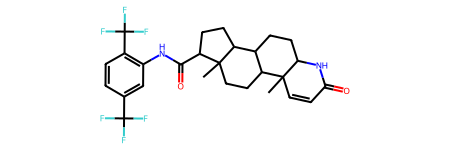


0 : C1C=CC=C1CC(=O)NCCCC(=O)NCCC(C(=O)NC2=CC=C(C(F)(F)F)C=C2)CC


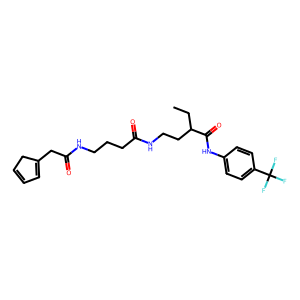


1 : C1C2=CC=C(C(=O)NCCC3C(=O)NCCC(C(=O)N4CC5CC(CC(C5)C4)C)C3)C=C2O1


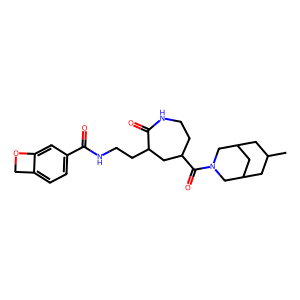


2 : CC=C1C=C(C(=O)NCCCC(=O)NCCC(C(=O)N2CCC(C3=CC=C(F)C=C3)CC2)C)C=C1O


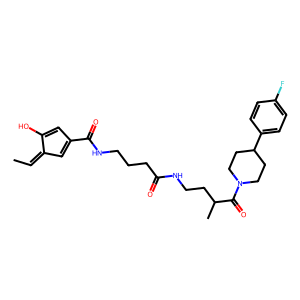


3 : C1C=CC=C1CC(=O)NCCCCC(=O)NCCN(C(=O)C2=CC=C(C(F)(F)F)C=C2)CCC


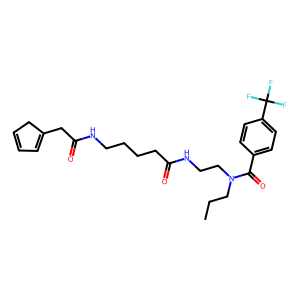


4 : C1C=C2C=C(CN3C(=O)C=CC=C(NC(=O)CN4C(=O)C5=CC=C(C(F)(F)F)C=C5C4)OC=C3)C=C12


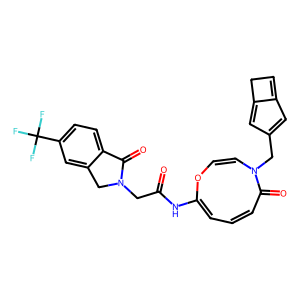


5 : C1C=CC2=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2C=C1C


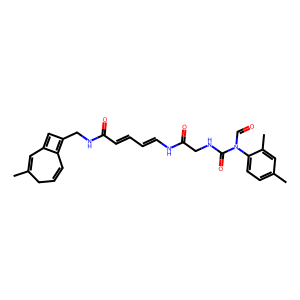


6 : CC=CC=C(CC(=O)NC1CCC(=O)N2CCC(C(=O)NC3=CC=C(C(F)(F)F)C=C3)CC2)C1=O


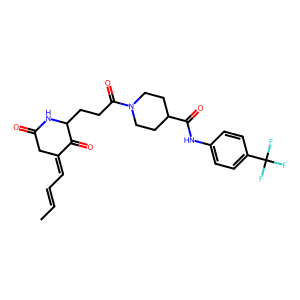


7 : CC1=CC=C(C(=O)NCCNC(=O)C=CC=C(NC(=O)CNC(=O)C2=CC=C(C)C(C)=C2)C=C)CC#C1


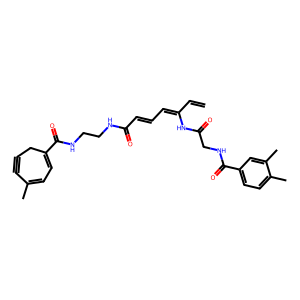


8 : C1C=CC=C1CC(=O)NCCCCC(=O)NCCC(C(=O)NC2=CC=C(C(F)(F)F)C=C2)CC


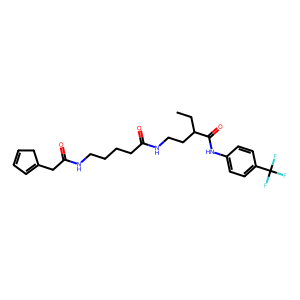


9 : CC=C1C=C(CNC(=O)C=CC2=C(NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N3CCCC3C)C)C)C2C=C1C


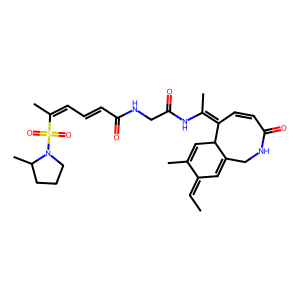


10 : C1C=CC2=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2C=C1


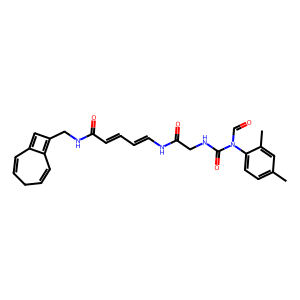


11 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)C2NC(=O)N(C3=CC=CC=C3)C(=O)C2=O)CC=C1OC


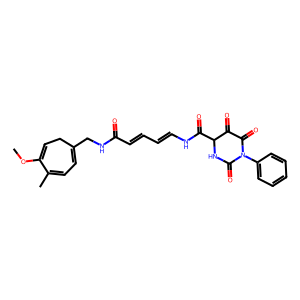


12 : CC=CC=C(C1NC(=O)C=CC=C(NC(=O)CNC(=O)C2=CC=C(S(=O)(=O)N3CCCCCC3)C)C2)C=C1C=CC


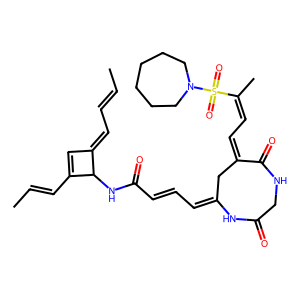


13 : CC=CC1=C(CNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)C2CC)C1O


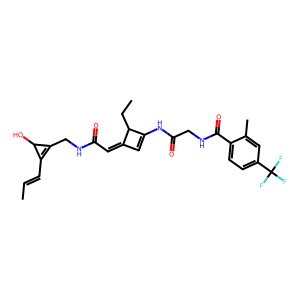


14 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)C=C1OC


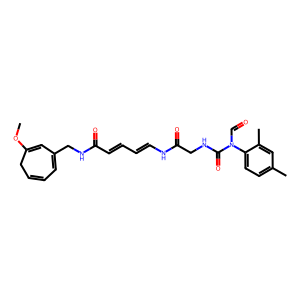


15 : C12C=CC=C(C=NN=C(NC(=O)CCCCN1C(=O)C3=CC=C(C(F)(F)F)C=C3CC)C)OC=C2C


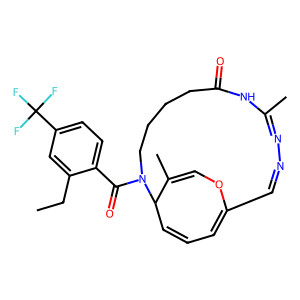


16 : CC1=C2C=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2C=C1


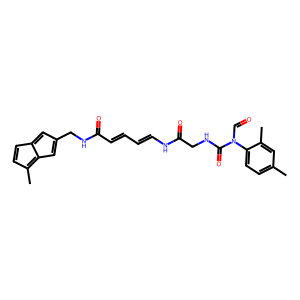


17 : CC=C1C2=C(CNC(=O)C=C3C=C(NC(=O)CNC(=O)C4=CC=C(C(F)(F)F)C=C4C)C3CC)C2O1


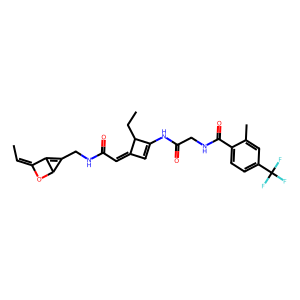


18 : CC=C1C=C(CNC(=O)C=CC=CNC(=O)C=CC=C(S(=O)(=O)NC2=CC=C(C)C=C2)C=C)C=C1


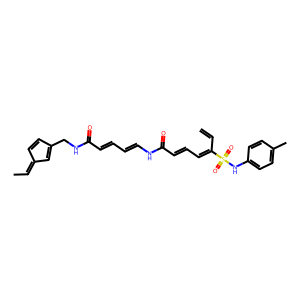


19 : CC1=CC=C(C(=O)NCCNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C)C(C)=C3)C=C2)CC#C1


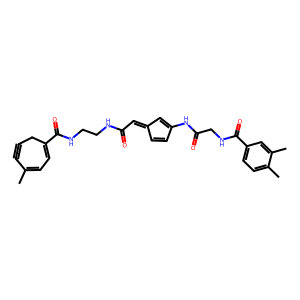


20 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)CC=C1C


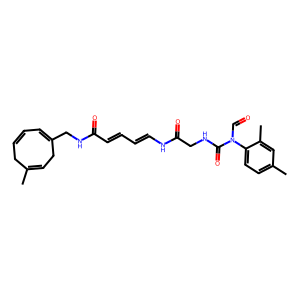


21 : CC1=CC=C(C2NC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(=O)C3=O)CC=C1


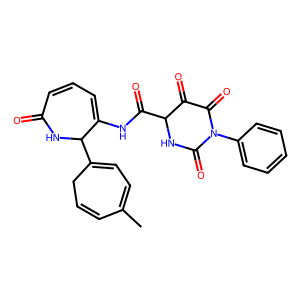


22 : CC=C1C=C(C(=O)NCCCC(=O)NCCC(C(=O)N2CCC(C3=CC=C(F)C=C3)CC2)C)C=C1


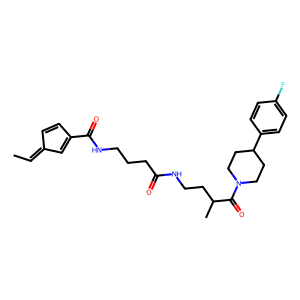


23 : CC=CC=C(CNC(=O)C=C1C=CNC(=O)CNC(=O)N(C2=C3C=CC=C2)C4=CC=CC=C4C3=C1)C=C=O


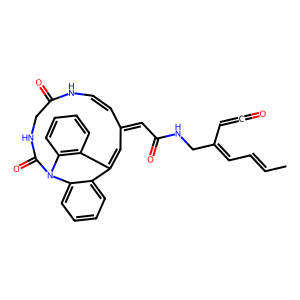


24 : C1C=CC=C1CNC(=O)C=C2C=CNC(=O)C=CC=C2NC(=O)C=CC=C(C(F)(F)F)C=C


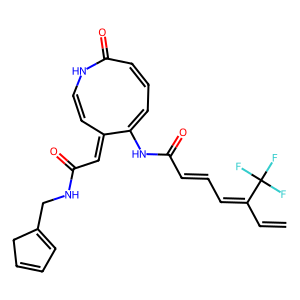


25 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)C(C)=C1C


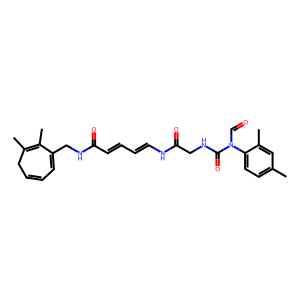


26 : CC=C1C=C(CNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)C2CC)C1OC


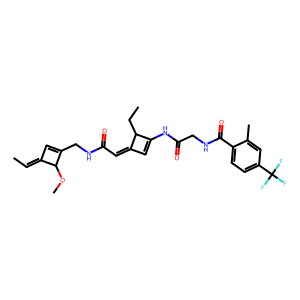


27 : CC=CC=C(C(=O)N1CCCC(=O)NCCC(C(=O)N2CC3CC(CC(C3)C2)C)C)C1=O


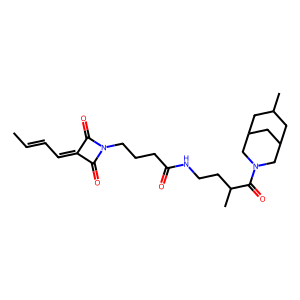


28 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)CC#C1


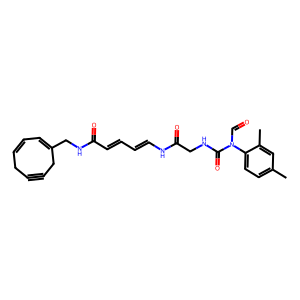


29 : CC=C1C=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC=C1C


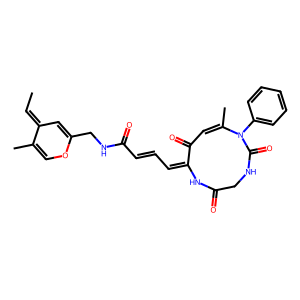


30 : CC1=CC=C(CC(=O)N2CCCCC(=O)N3CCC(C(=O)NC4CCC(C5=CC=CC=C5)CC4)C3)C2=C1C


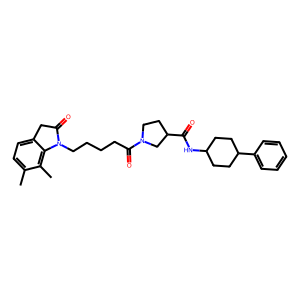


31 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)CC=C1


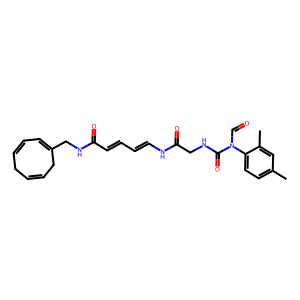


32 : CC=C1C=C(CNC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(C)=C3C2=O)OC=C1C


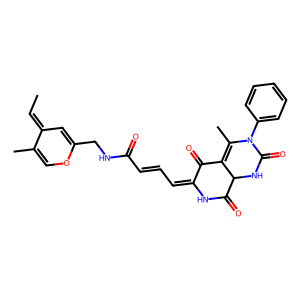


33 : C1C=CC2=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C21


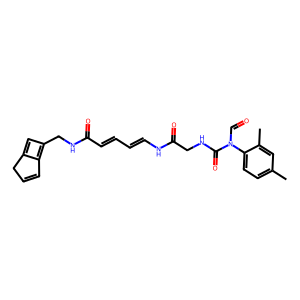


34 : CC1=CC=C(CC(=O)NCC2CC(C(=O)N3CCCC(C(=O)NC4=CC=C(C)C(C)=C4)C)C3C2)OC#C1


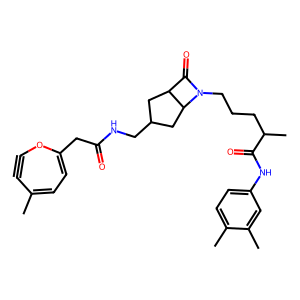


35 : C1C=CC=C(C(=O)NCCC2C(=O)NCCC(C(=O)N3CCC(C4=CC=C(OC)C=C4)CC3)C2)C#C1


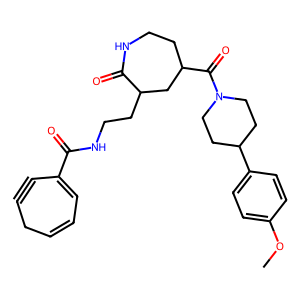


36 : CC1=CC=C(C2NC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(=O)C3=O)CC=C1OC=C


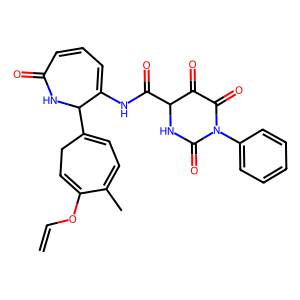


37 : CC=CC=C(C1NC(=O)C=CC=C(NC(=O)CNC(=O)C2=CC=C(S(=O)(=O)N3CCCCCC3)C)C2)C=C1


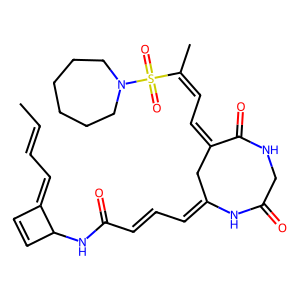


38 : C1C=CC=C1CC(=O)NCCCCC(=O)N2CCC(C(=O)NCCC(CC3=CC=CC=C3C)C)C2C


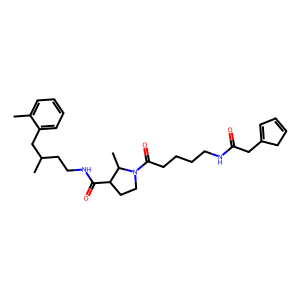


39 : CC=C1C=C(CNC(=O)C2=CC=C(NC(=O)C3NC(=O)N(C4=CC=CC=C4)C5=CC=CC=C53)C2=O)C(C)=C1


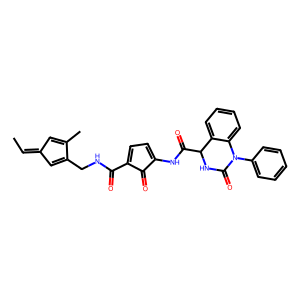


40 : C1C=CC=C1CNC(=O)C=CC=CNC(=O)C2NC(=O)N(CC3=CC=CC=C3)C(=O)C2C=O


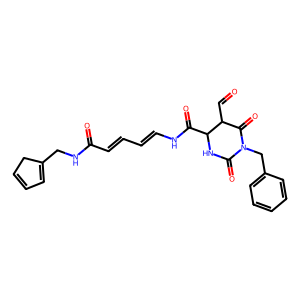


41 : C12C3=CC=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)C4=CC=C(C(F)(F)F)C=C4C)NC=C3O2


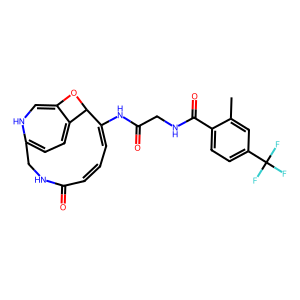


42 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)C1C


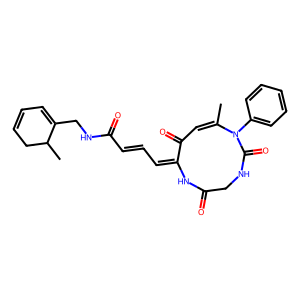


43 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(C)=C3C2=O)OC=C1C


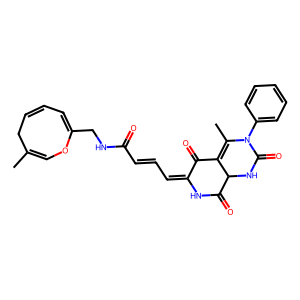


44 : CC1=CC=C(C(=O)NCCC2C(=O)NCCC(C(=O)N3CCC(C4=CC=C5OCOC5=C4)CC3)C2)C#C1


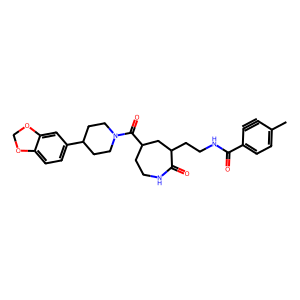


45 : CC=CC1=C(CC(=O)NCCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C=C1OC


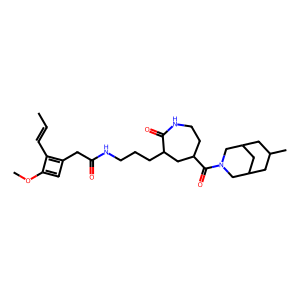


46 : CC1=CC=C(CC(=O)NC2C3CC(=O)NCCC(C(=O)N4CCC(C)(C)CC4CCCCC)C3)C2C=C1C


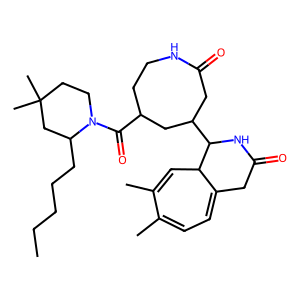


47 : C1C=CC=C(C(=O)N2CCNC(=O)C=CC=C2NC(=O)C=CC=C(C(F)(F)F)C=C)C(C)=C1


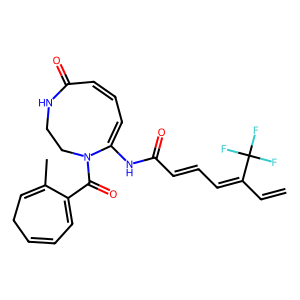


48 : C1C=CC=C(CCNC(=O)C=CC=C1NC(=O)CNC(=O)C2=CC=C(C)C(C(F)(F)F)=C2C=C)C(C)=C


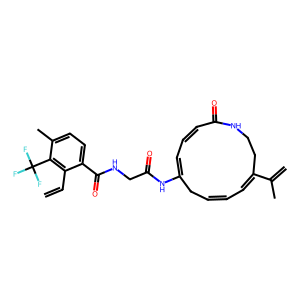


49 : C1C=CC2=C1CNC(=O)C=CC=CNC(=O)C=CC=C2NC(=O)C3=CC=C(C)C(C)=C3C=C


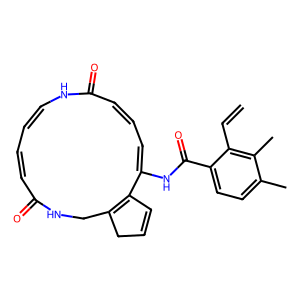


50 : CC=C1C=C(CNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)C2CC)CO1


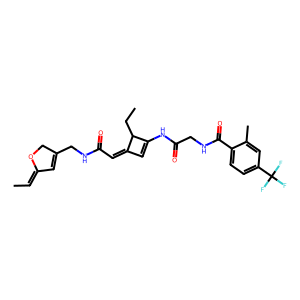


51 : C1C=C2C=C(C=NN=C(NC(=O)CCCCN1C(=O)C3=CC=C(C(F)(F)F)C=C3CC)C)OC=C2


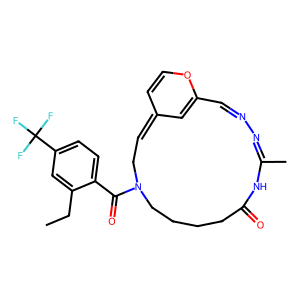


52 : CC1=CC=C(CNC(=O)C=CC=CN2C(=O)C=CC=C(S(=O)(=O)NC3=CC=C(C)C=C3)C=CC)C2C=C1C


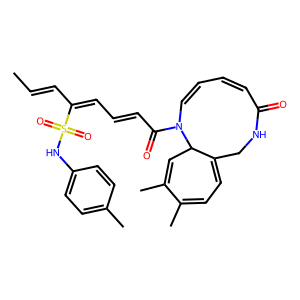


53 : C=1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)C=C=1


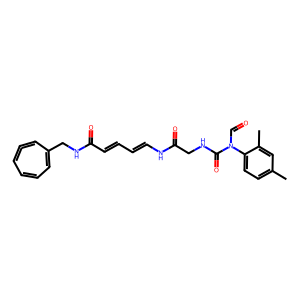


54 : C12C=CC=C(C3=NN=C(NC(=O)CCCCN1C(=O)C4=CC=C(C(F)(F)F)C=C4CC)C)OC=C32


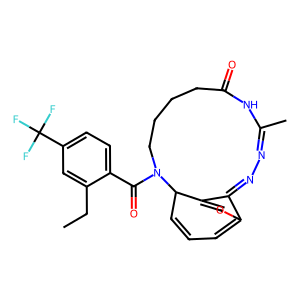


55 : C1C=CC=C1CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O


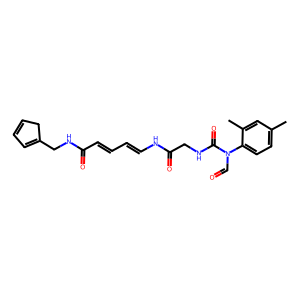


56 : CC1=CC=C(CC(=O)NCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C=C1O


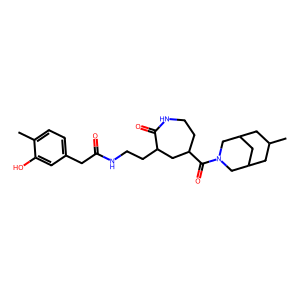


57 : C1C=CC=C(CC(=O)N2CCC(C(=O)N3CCCCC(=O)NC4=CC=C([N+1](=O)[O-1])C=C4)CC3C2)C#C1


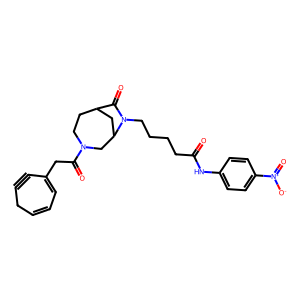


58 : CC=C1C=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC=C1


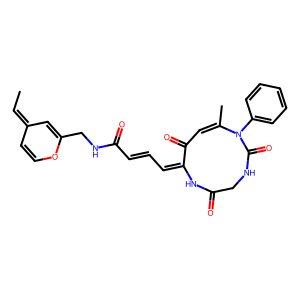


59 : CC=CC1=C(CNC(=O)C2=CC=C(NC(=O)CNC(=O)C(C)(C)CCC(=O)N3CCOCC3)C2)OC=C1


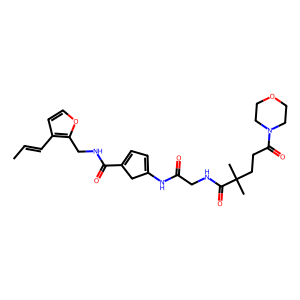


60 : CC1=CC=C1NC(=O)CC2CCNC(=O)C=CC=C2NC(=O)C=CC=C(C(F)(F)F)C=C


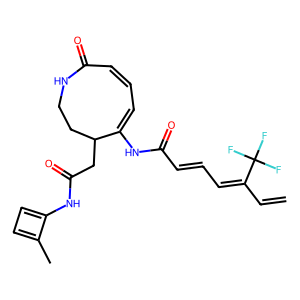


61 : C1C=CC=C1CNC(=O)C=CC=CNC(=O)C2NC(=O)N(C3=CC=CC=C3)C(=O)C2=O


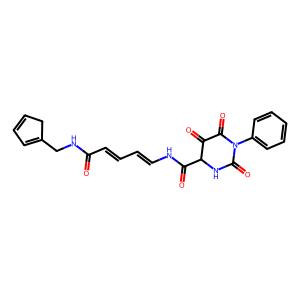


62 : CC1=CC=C(CC(=O)NC2CCC(C(=O)NCCCC(C(=O)NC3=CC=C(C)C(C)=C3)C)CC2)OC#C1


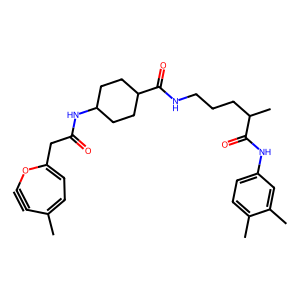


63 : CC1=CC=C(C2NC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(=O)C3=O)CC=C1C


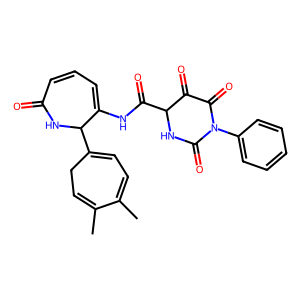


64 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C3=C2C)C=O)C3C=C1C


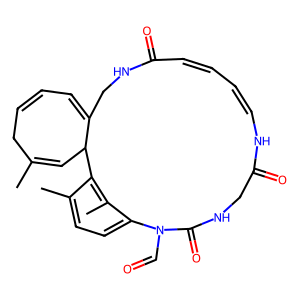


65 : C1C=CC=C1CCNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)C2CC(=O)O


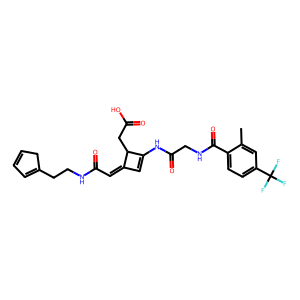


66 : CC1=CC2=C(CC(=O)NCCCCC(=O)NCCC(C(=O)NC3CCC(C4=CC=CC=C4)CC3)C)C=C12


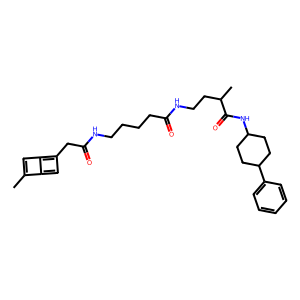


67 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)OC=C1C


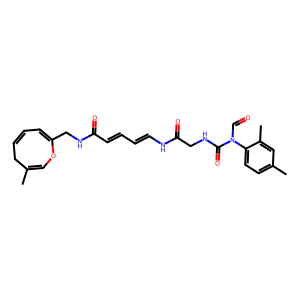


68 : C1C=CC=C1CC(=O)NCCC(C(=O)N2CCC(C(=O)N3CCC(CC4=CC=CC=C4)CC3)C2)C


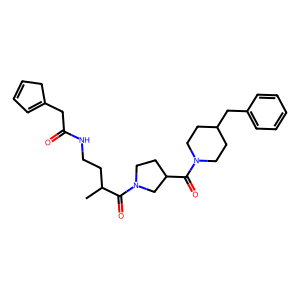


69 : C12C=CC=C2C(=O)NCCCC(=O)NCCC1(C(=O)NC3=CC=C(C(F)(F)F)C=C3CC)C


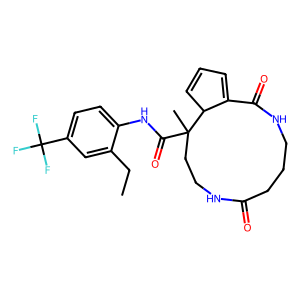


70 : CC=C1C=C(CCNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)C2CC)C1


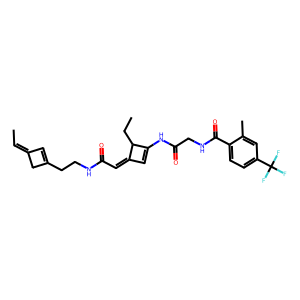


71 : CC=CC1=C(CN2C(=O)C=CC=C(NC(=O)CN3C(=O)C4=CC=C(C(F)(F)F)C=C4C3)OC=C2)C=C1OC


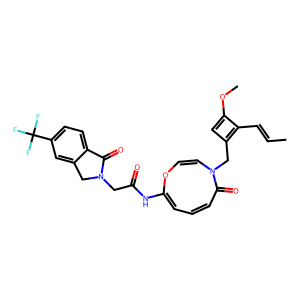


72 : CC1=CC=C(CNC(=O)C2=CC=C(NC(=O)C3NC(=O)N(C4=CC=CC=C4)C5=CC=CC=C53)C2=O)C#C1


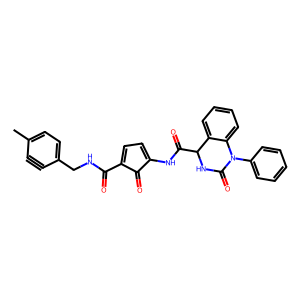


73 : CC=CC=C(C(=O)NCCCC(=O)NCCC(C(=O)N1CC2CC(CC(C2)C1)C)C)C=O


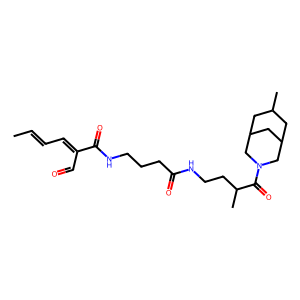


74 : C1C=C2C=C(CNC(=O)C=CC=CNC(=O)C34NC(=O)N(C5=CC=CC=C5)C(=O)C3C4=O)C=CC=C12


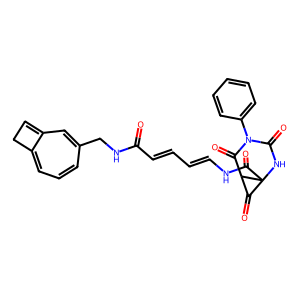


75 : CC=C1C=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=CC=C2)C(C)=CC=O)OC=C1OC


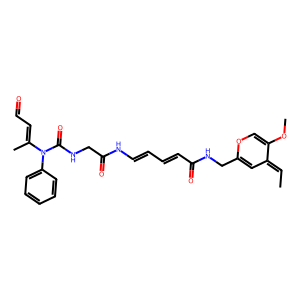


76 : C12C=CC=C2CCCCCNC(=O)C=CC=C1NC(=O)CNC(=O)C3=CC=C(C)C(C)=C3C=C


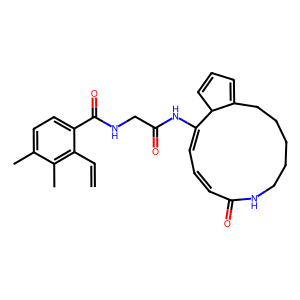


77 : CC1=CC=C(CN2C(=O)CNC(=O)C(=CC3=CC=C(C(F)(F)F)C=C3)C(C)=C2C(=O)NC4C)CCCC41C


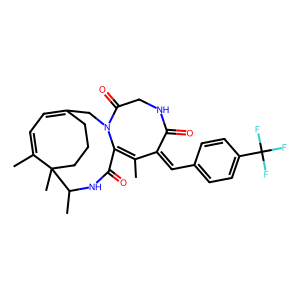


78 : CC=CC1=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C)C2=CC=C(S(=O)(=O)N3CCCCC3)C)C2C#C1


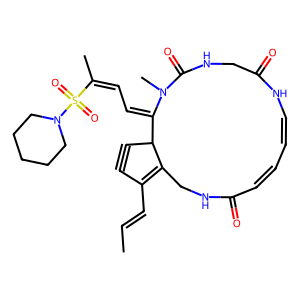


79 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)C=C1O


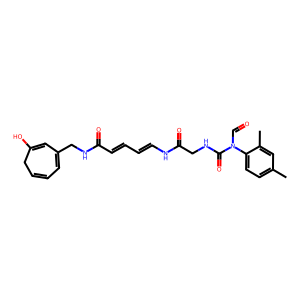


80 : C1C=C2C=C(C=NN=C(NC(=O)CCCCN1C(=O)C3=CC=C(C(F)(F)F)C=C3CC)C)OC=C2OC


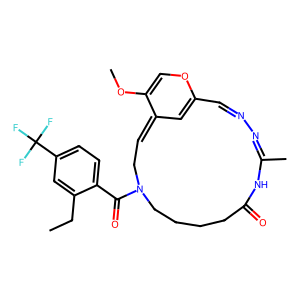


81 : C1C2=CC=C(C3NC(=O)C=CC=C3NC(=O)C4NC(=O)N(C5=CC=CC=C5)C(=O)C4=O)CC=C2C1C


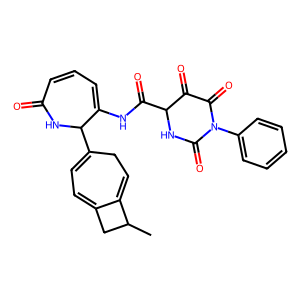


82 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC(C)=C1C


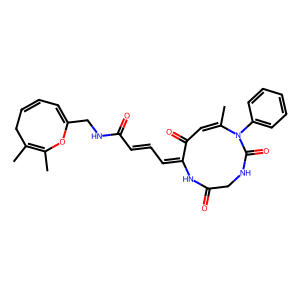


83 : C1C=CC=C(C2C(=O)NCCC3C(=O)NCCC(C(=O)N4CC5CC(CC(C5)C4)C)C3)C=C21


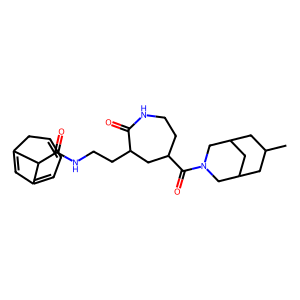


84 : CC=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C1=CC=C2C=C1)C(C3)=CC=O)C=C32


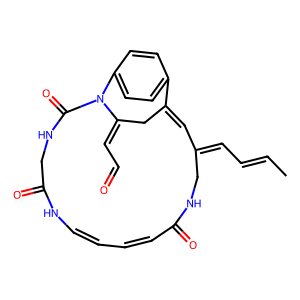


85 : CC=C1C=C(CNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)C2CC)C1O


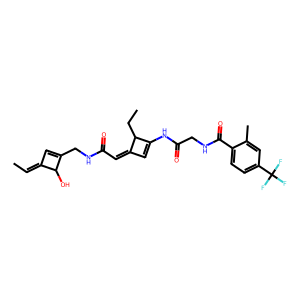


86 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=CC=C2)C(C3)=CC=O)C=C3C#C1


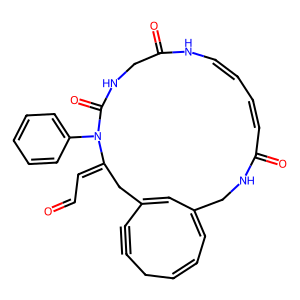


87 : CC=CC1=C(C(=O)NCCC2C(=O)NCCC(C(=O)N3CCC(C4=CC=C(OC)C=C4)CC3)C2)C=C1


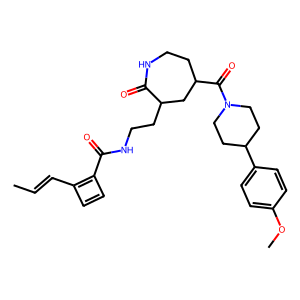


88 : C=1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C3=C2C)C=O)C3C=C=1


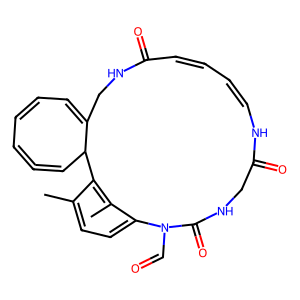


89 : C1C=CC=C1C2NC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(=O)C3=O


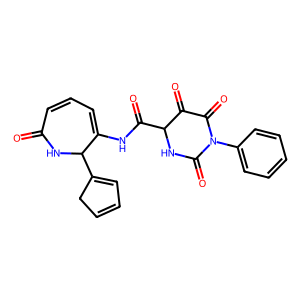


90 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)C23NC(=O)N(C4=CC=CC=C4)C(=O)C2C3=O)C=C1OC


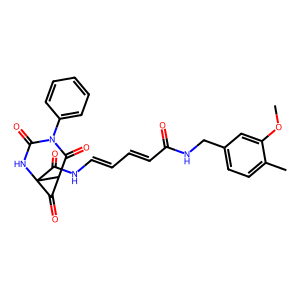


91 : C1C=CC=C(CC(=O)NCCCC(=O)N2CCC(C(=O)N3CCC(C4=CC=C(F)C=C4)CC3)C2)C#C1


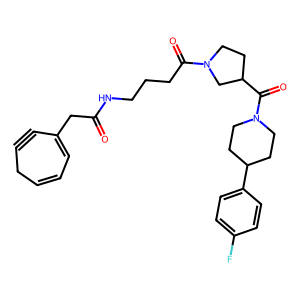


92 : CC1=CC=C(C(=O)NCCCC(=O)N2CCC(C(=O)NCCC(C3=CC=C(C)C=C3C)C)C2)C=CC=C1C


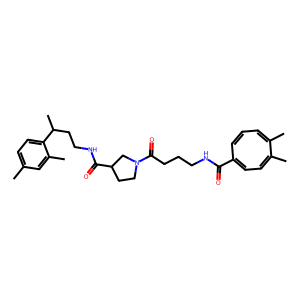


93 : CC=CC1=C(C2NC(=O)C3=CC=C(NC(=O)C4NC(=O)N(C5=CC=CC=C5)C6=CC=CC=C64)C3=O)C=C2C=C1C


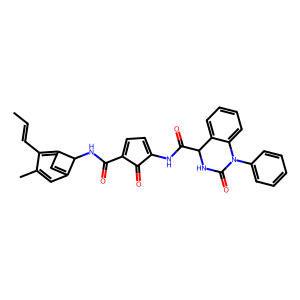


94 : CC=CC=C(CNC(=O)C=CC=C(N1C(=O)CNC(=O)C2=CC=C(S(=O)(=O)N3CCCCCC3)C)C2)C=C1C=CC


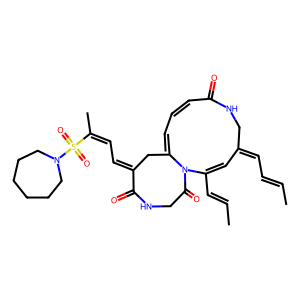


95 : CC1=CC=C(CC(=O)NC2CCC(C(=O)NCCCC(C(=O)NC3=CC=C(C)C(C)=C3)C)CC2)OC=C1C


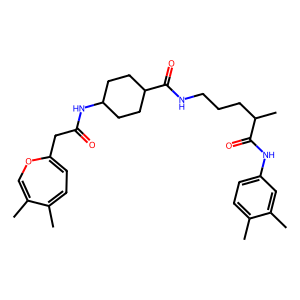


96 : C1C=CC=C(C2C(=O)NC3CC(C(=O)N4CCCC(C(=O)NC5=CC=C(C)C(C)=C5)C)C4C3)C=C21


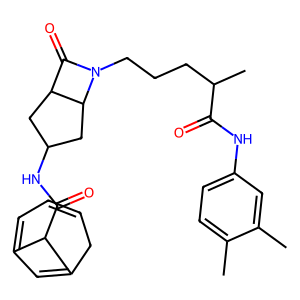


97 : C1C=CC=C1CNC(=O)C=CC=CNC(=O)C2NC(=O)N(C3=CC=CC=C3)C(=O)C2C4=CC=CC=C4


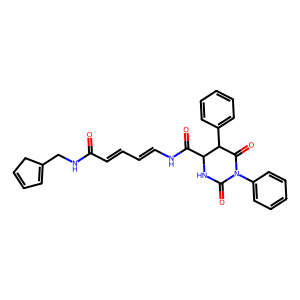


98 : CC1=CC=C(CC(=O)NCCCC(=O)NCCC(C(=O)N2CC3CC(CC(C3)C2)C)C)C(C)=C1


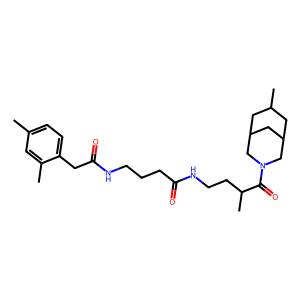


99 : CC=CC1=C(C(=O)NCCCC(=O)N2CCC(C(=O)N3CCC(C4=CC=C(OC)C=C4)CC3)C2)C=C1


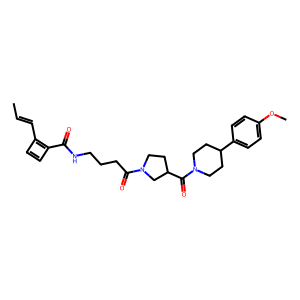


100 : C1C=CC=C(C(=O)NCCCC(=O)N2CCC(C(=O)NC3CCC(C4=CC=C(F)C=C4)CC3)C2)C#C1


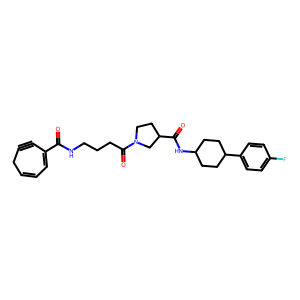


101 : C1C=CC=C(CN2C(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C2C=C1C


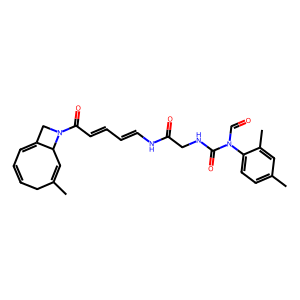


102 : CC=CC1=C(CNC(=O)C2=CC=C(NC(=O)CNC(=O)N(C3=CC=CC=C3)C4=CC=CC=C4)C2=O)C=CC=C1C


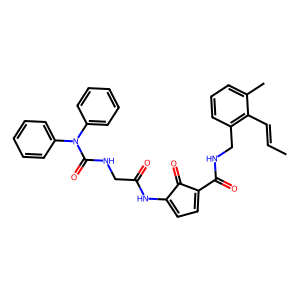


103 : C12C=CC=C2C(=O)NCCCC(=O)NCCC1(C(=O)NCCC(C3=CC=C4OCOC4=C3)CC)C


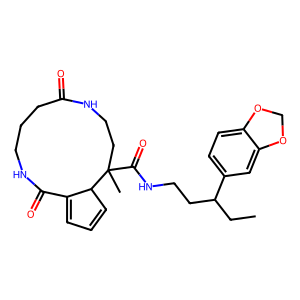


104 : CC=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C1=C2C=CC=C1)C3=CC=CC=C3C2=O)N=O


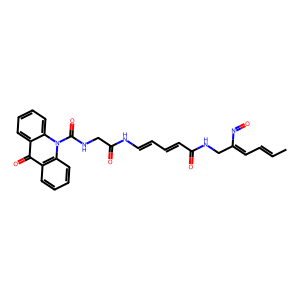


105 : C12C=CC=C(C=NN=C(NC(=O)CCCCN1C(=O)C3=CC=C(C(F)(F)F)C=C3CC)C)OC#C2


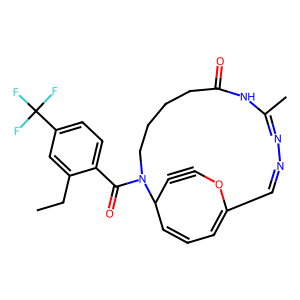


106 : C=1C=CC=C(CNC(=O)C=CC=CNC(=O)C23NC(=O)N(C4=CC=CC=C4)C(=O)C2C3=O)C=CC=C=1


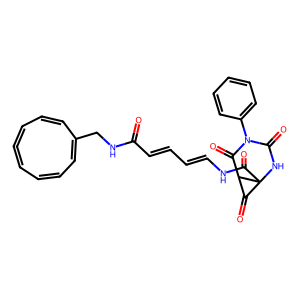


107 : C12C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C1O2


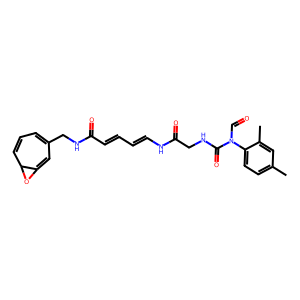


108 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(C)=C3C2=O)OC#C1


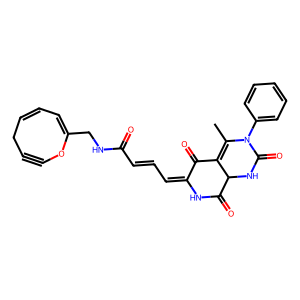


109 : C1C=C2C=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)N(C3=C4C=CC=C3)C5=CC=CC=C5C4=O)OC#C2


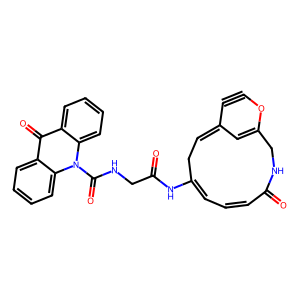


110 : C12C=CC=C(C3=NN=C(N4C(=O)CCCCN1C(=O)C5=CC=C(C(F)(F)F)C=C5C=C)CC4)C=C3O2


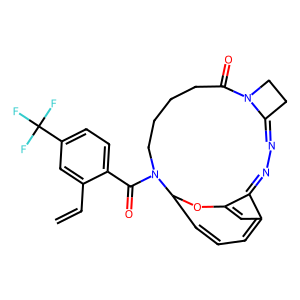


111 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC1(C)C


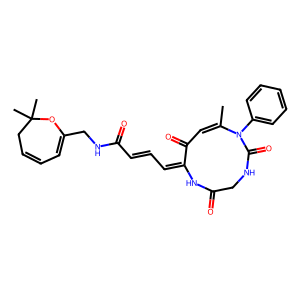


112 : C1C=CC=C1CNC(=O)C=CC=C(NC(=O)CNC(=O)C=CC=C(S(=O)(=O)NCCCCC)C)C=C


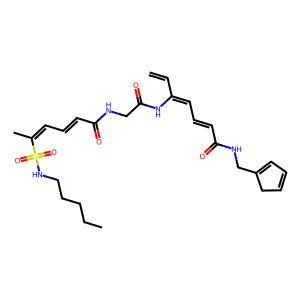


113 : C123C=CC=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)C4=CC=C(C(F)(F)F)C=C4C)C=C2O3


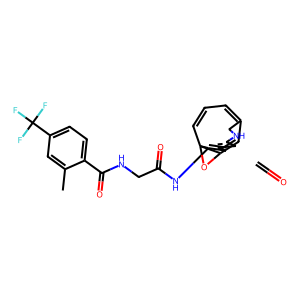


114 : CC=C1C=C(CC(=O)NCCCCC(=O)NCCC(C(=O)NC2=CC=C(C(F)(F)F)C=C2)CC)C1OC


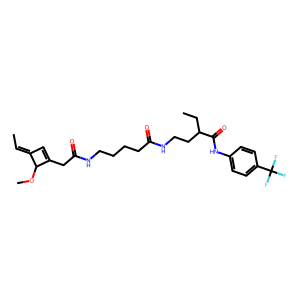


115 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC#C1


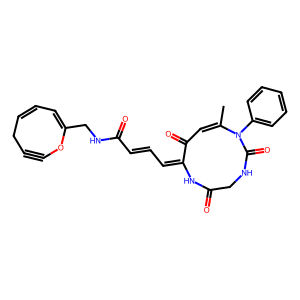


116 : CC=C1C=C(CC(=O)NCCCC(=O)NCCC(C(=O)N2CC3CC(CC(C3)C2)C)CC)C1O


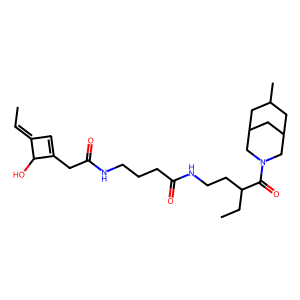


117 : CC1=CC2=C(CNC(=O)C=C3C=C(NC(=O)CNC(=O)C4=CC=C(C(F)(F)F)C=C4C)C3CC)C21


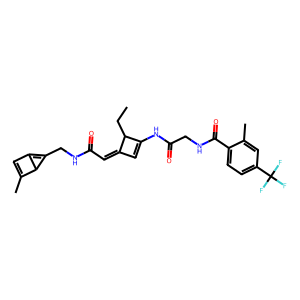


118 : C1C=CC2=C(CC(=O)NCCC3C(=O)NCCC(C(=O)N4CC5CC(CC(C5)C4)C)C3)C=C21


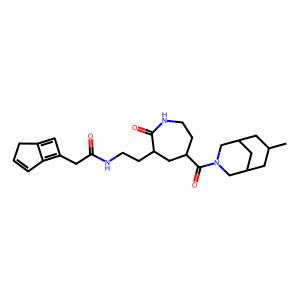


119 : C1C=C2C=C(C(=O)NCCCC(=O)NCCC(C(=O)N3CCC(C4=CC=C(F)C=C4)CC3)C)C=C2O1


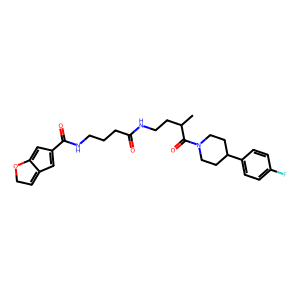


120 : C1C=C2C=C(C3NC(=O)C=CC=C1NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N4CCCCC4C)C)C3C#C2


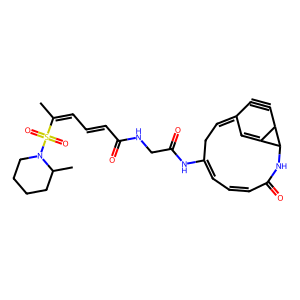


121 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)C2NC(=O)N(C3=CC=CC=C3)C(=O)C2=O)CC=C1C


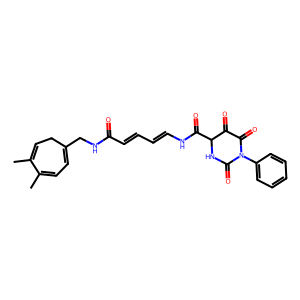


122 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=CC=C2)C(C)=CC=O)OC(C)=C1C


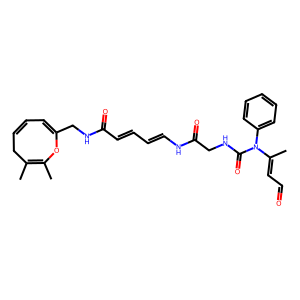


123 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)OC(C3)=C13


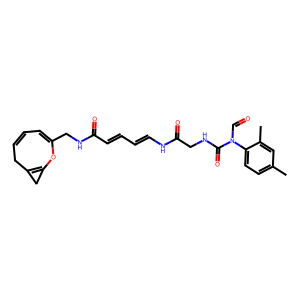


124 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CN2C(=O)N(C)C(C)=C(C)C(C)=C2C=O)OC(C)=C1C


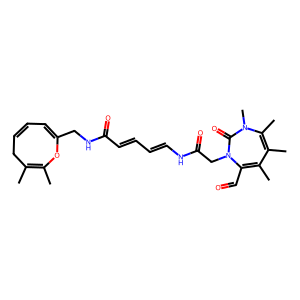


125 : C1C2=CC=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)NC=C2OC


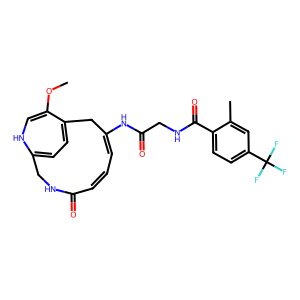


126 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC=C1C


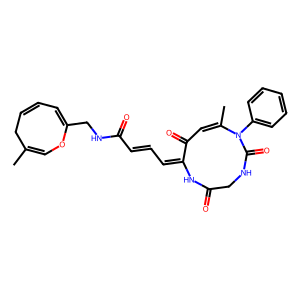


127 : C1C=CC2=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2O1


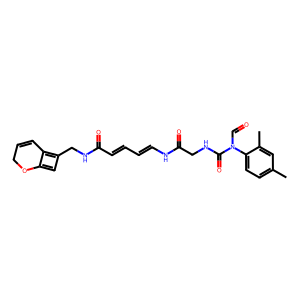


128 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C3=C2C)C=O)C3C#C1


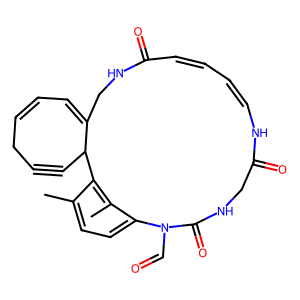


129 : C1C=CC=C1CC(=O)NCCC(C(=O)NCCC(C(=O)NC2=CC=C(C(F)(F)F)C=C2)C)C


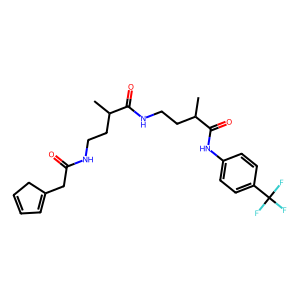


130 : C1C=CC=C1CNC(=O)C=CC=CNC(=O)CNC(=O)NCCN(C(=O)C2=CC=C(C)C(C)=C2)C


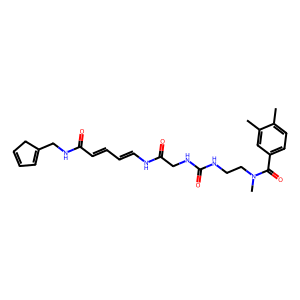


131 : CC1=CC=C(C(=O)NCCC2C(=O)NCCC(C(=O)N3CCC(C4=CC=C5OCOC5=C4)CC3)C2)C=C1C


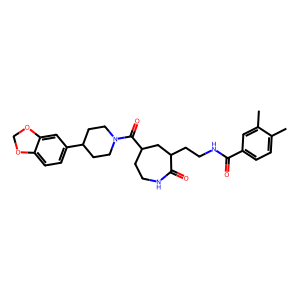


132 : C1C=CC=C1CNC(=O)C=CC=CNC(=O)C2=CC=C(S(=O)(=O)NC3=CC=C(C)C=C3)C=C2C=C


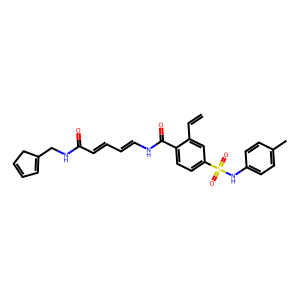


133 : C1C=CC=C(C(=O)N2CCCC(=O)NCCN(C(=O)C3=CC=C(C(F)(F)F)C=C3C)CC2)OC#C1


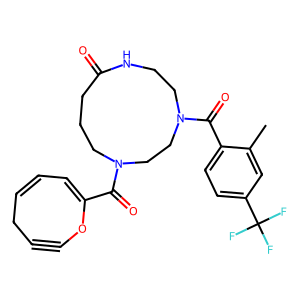


134 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)C(C4)=C14


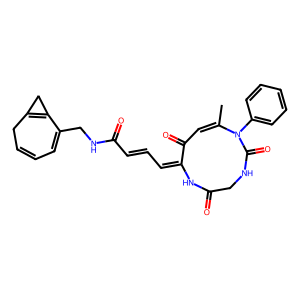


135 : CC1=CC=C(C(=O)NC2CNCC(=O)NCCN(C(=O)C3=CC=C(C(F)(F)F)C=C3)CC)C2C=C1


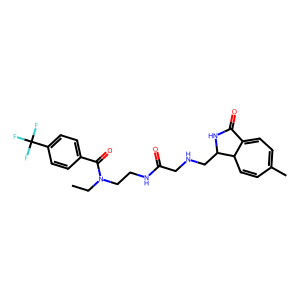


136 : CC=C1C=C(C(=O)NCCCC(=O)N2CCC(C(=O)NCCC(C3=CC=C(C)C=C3C)C)C2)C=C1O


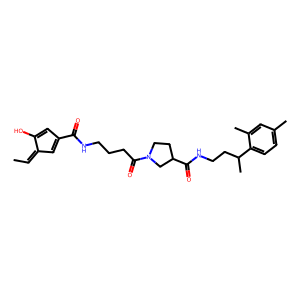


137 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)C#C1


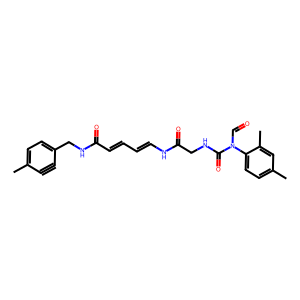


138 : CC1=CC=C(C2NC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2C=C1


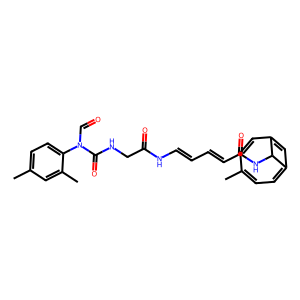


139 : CC=C1C=C(CNC(=O)C2=CC=C(NC(=O)C3NC(=O)N(C4=CC=CC=C4)C5=CC=CC=C53)C2=O)C=C=C1


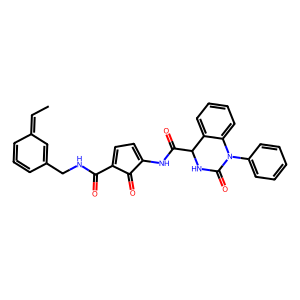


140 : C12C=CC=C(C3=NN=C1NC(=O)CCCCN(C(=O)C4=CC=C(S(=O)(=O)N(C)C)C=C4)C)C32


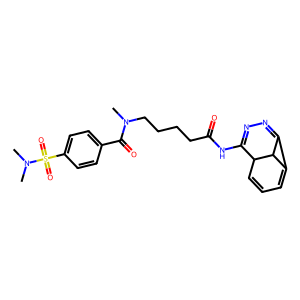


141 : CC1=CC=C(CC(=O)NC2CC(C(=O)N3CCCCC(=O)NC4=CC=C(C(C)=O)C=C4)CC3C2)OC#C1


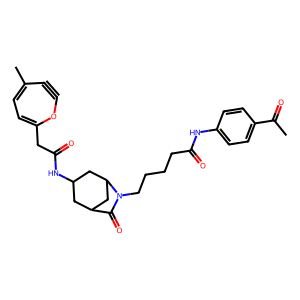


142 : CC=CC=C(CC(=O)NCCC1CC(=O)N2CCC(C(=O)NCCCC(C3=CC=CC=C3)CC)C2)C1=O


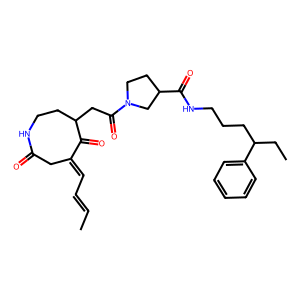


143 : CC=C1C=C(C=NN=CNC(=O)CNC(=O)C=CC=CS(=O)(=O)N2CCCCCC2C=C)CC=C1


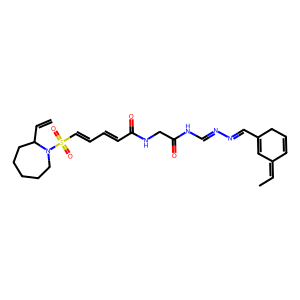


144 : C1C=CC=C(CNC(=O)C2=CC=CNC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC(C)=C1C


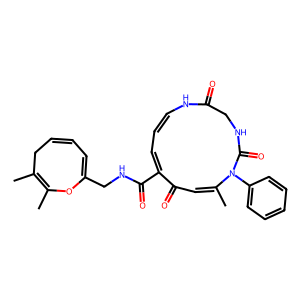


145 : CC1=CC=C(CC(=O)NCCCCC(=O)NCCC(C(=O)N2CCC(C)(C)CC2CCC)CC)C1


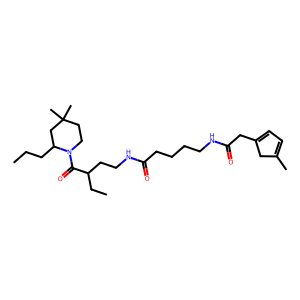


146 : CC1=CC=C(CC(=O)NCCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C=C1


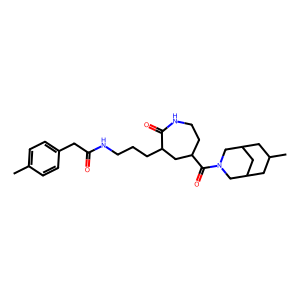


147 : C1C=C2C=C(C3NC(=O)C=CC=C1NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N4CCCCC4)C=C)C3C=C2C


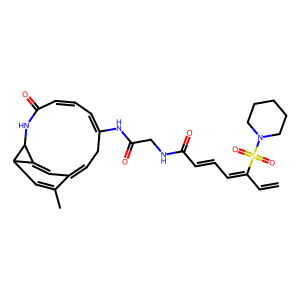


148 : CC1=CC=C(CC(=O)N2CCCC(=O)N3CCC(C(=O)N4CCC(C5=CC=C(F)C=C5)CC4)C3)C=C2C1C


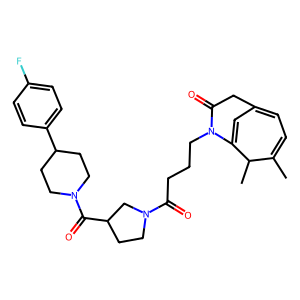


149 : C1C=CC=C1C(=O)N2CCCC(=O)NCCC2(C(=O)N3CC4CC(CC(C4)C3)CC)C


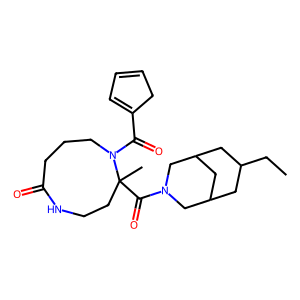


150 : C1C=CC=C(CC(=O)NCCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C#C1


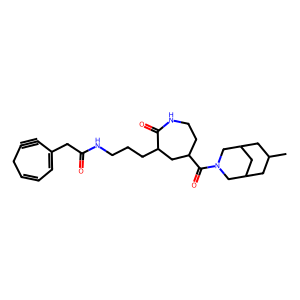


151 : CC=C1C=C(CC(=O)NCCCCC(=O)NCCC(C(=O)NC2=CC=C(C(F)(F)F)C=C2)CC)C1C


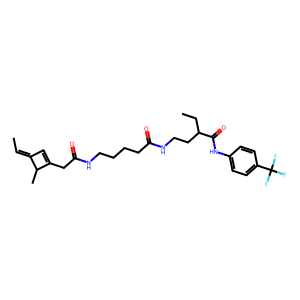


152 : CC1=CC=C(CNC(=O)C(C)N(CC2=CC=C(F)C=C2)C(C)=C(C)N(C3=CC=C(C)C=C3)C=O)CC#C1


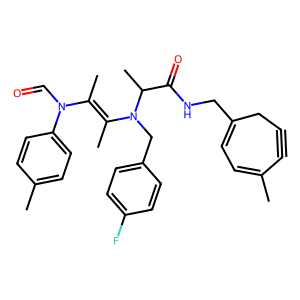


153 : CC1=C2C=C(C(=O)NCCCC(=O)N3CCC(C(=O)NCCC(C4=CC=C(F)C=C4C)C)C3)C=C21


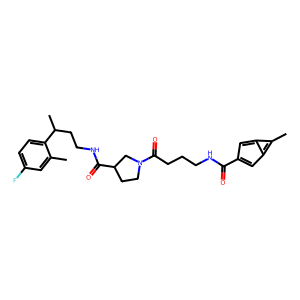


154 : C1C2=CC=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)NC=C2O


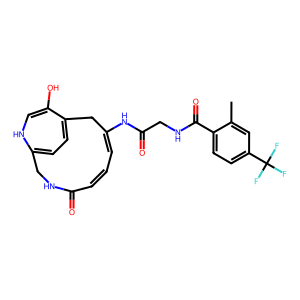


155 : C1C=CC=C(CC(=O)NCCCC(=O)N2CCC(C(=O)N3CCC(C4=CC=C(F)C=C4)CC3)C2)C=C1


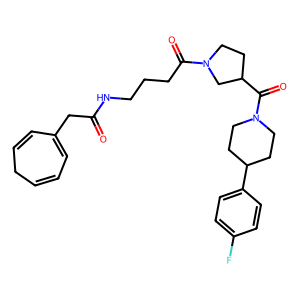


156 : CC=C1C=C(C(=O)NCCCC(=O)N2CCC(C(=O)NCCC(C3=CC=C(F)C=C3C)C)C2)C=C1O


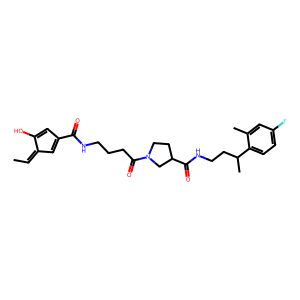


157 : C1C=CC=C(C2C(=O)NCCCC(=O)N3CCC(C(=O)N4CCC(C5=CC=C(F)C=C5)CC4)C3)C=C21


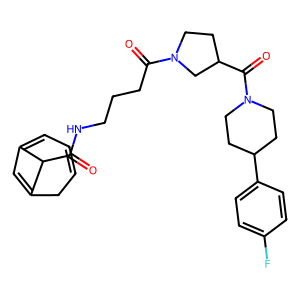


158 : CC=C1C=C(C=NN=C(NC(=O)CC2CCNC(=O)C3=CC=C(C(F)(F)F)C=C3CC2)C)OC=C1OC


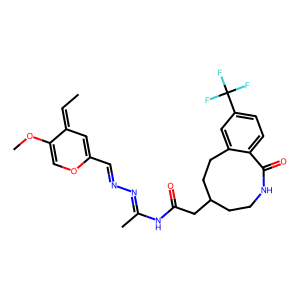


159 : C12C=CC=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)NC#C2


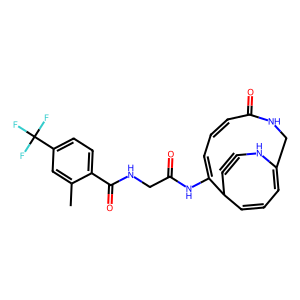


160 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)C23NC(=O)N(C4=CC=CC=C4)C(=O)C2C3=O)C=C1C


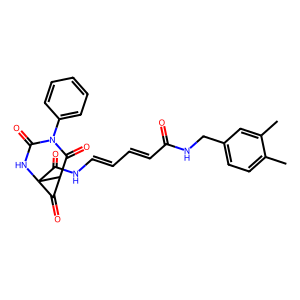


161 : C1C=CC=C1CNC(=O)C=CC=C(NC(=O)CNC(=O)C2=CC=C(S(=O)(=O)N3CCCC3)C)C2C=C


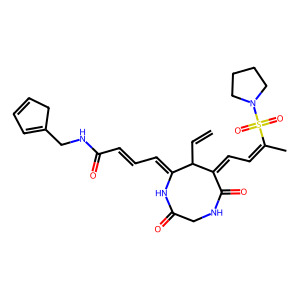


162 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC(C4)=C14


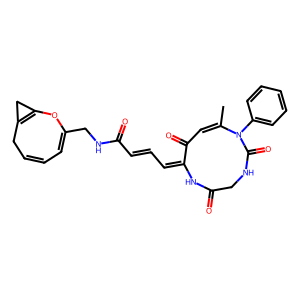


163 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)C2NC(=O)N(C3=CC=CC=C3)C(=O)C2=O)CC=C1C


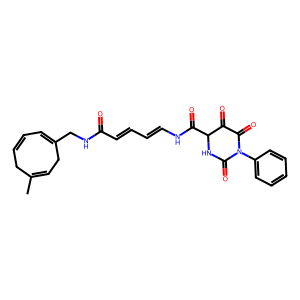


164 : C1C=CC=C(C(=O)NCC2CC(=O)NCCC(C(=O)N3CCC(C4=CC=C(OC)C=C4)CC3)C2)C#C1


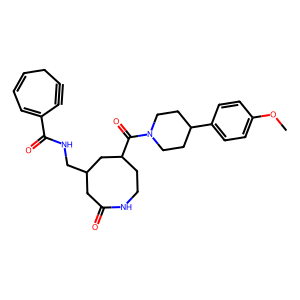


165 : CC=CC1=C(CNC(=O)C=CC2=CNC(=O)C=CC=C(S(=O)(=O)NC3CCCCCC3C)C2)OC=C1OC


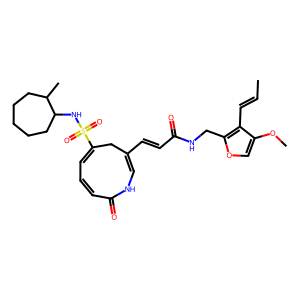


166 : C1C2=C3C=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)C4=CC=C(C(F)(F)F)C=C4C)NC=C3C2


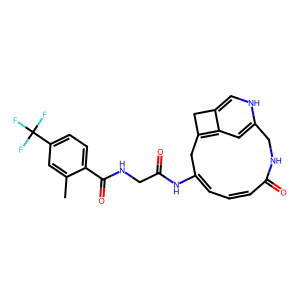


167 : C1C=CC=C(C(=O)NCCCC(=O)N2CCC(C(=O)N3CCCC(C(=O)N4CCCC4C)C3)C2)C#C1


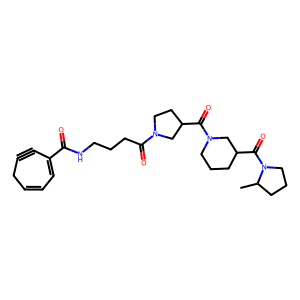


168 : C1C=CC=C1CNC(=O)C=CC=CNC(=O)C2NC(=O)N(CC3=CC=CC=C3)C(=O)C2C4=CC=CC=C4


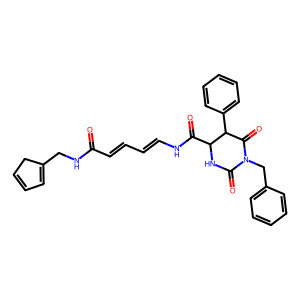


169 : CC=C1C=C(CC(=O)NCCCC(=O)NCCC(C(=O)N2CC3CC(CC(C3)C2)C)C)C=C1O


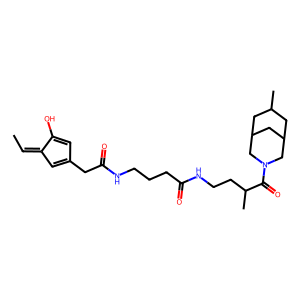


170 : CC=CC1=C(CNC(=O)C=CC=C2NC(=O)C=CC=C(S(=O)(=O)N3CCCC(C)C3)C=CC=C2)C=C1


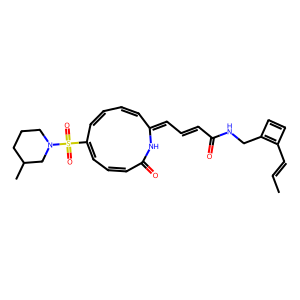


171 : C12C=CC=C(CC(=O)N3CCCC(=O)NCCC1(C(=O)NC4=CC=C(C(F)(F)F)C=C4C)C3)OC=C2


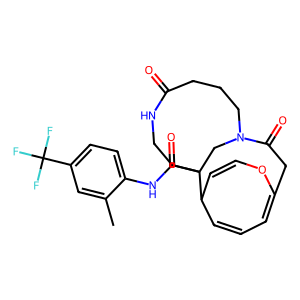


172 : CC=C1C=C(CC(=O)NC2CCCC(=O)NCCC2(C(=O)NC=CC=C(C(F)(F)F)C=C)C)C=C1O


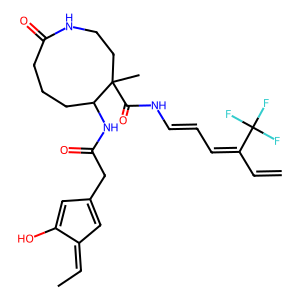


173 : C1C=CC=C1CNC(=O)C2=CC=CNC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O


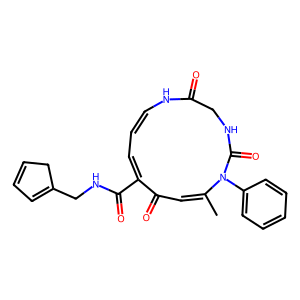


174 : C1C=CC=C(CC(=O)NCCCC(=O)NCCC(C(=O)N2CC3CC(CC(C3)C2)C)C)C1C


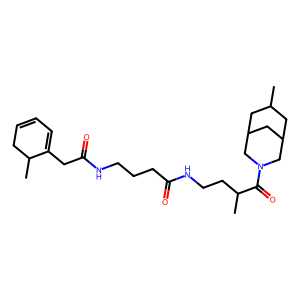


175 : CC=C1C=C(CNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(S(=O)(=O)N4CCCC4)C)C3C)C2C=C1C


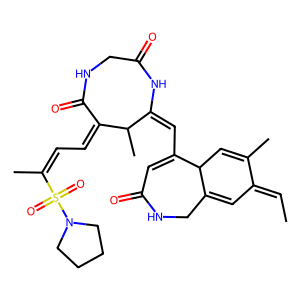


176 : CC=C1C=C(CNC(=O)C=CC2=C(NC(=O)CNC(=O)C3=CC=C(S(=O)(=O)N4CCCC4)C)C3C)C2C#C1


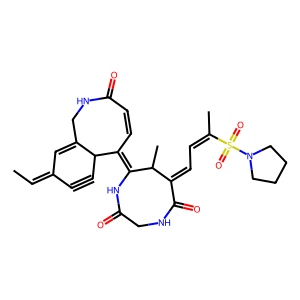


177 : C1C=C2C=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2O1


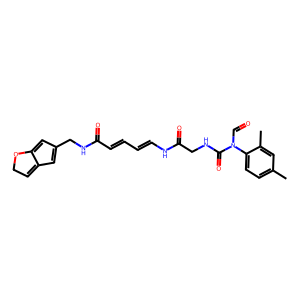


178 : C1C=CC=C(C(=O)N2CCNC(=O)C=CC=C2NC(=O)C=CC=C(C(F)(F)F)C=C)C1C


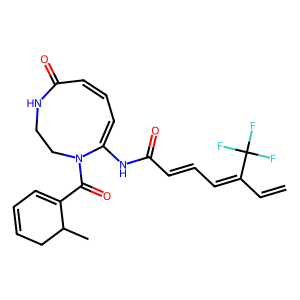


179 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=CC=C2)C(C)=CC=O)OC(C3)=C13


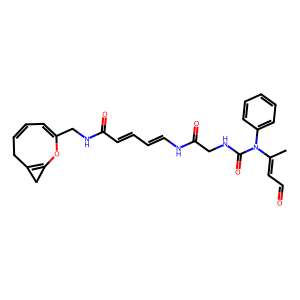


180 : CC1=CC=C(CNC(=O)C=C2C=CNC(=O)C=CC=C(S(=O)(=O)NC3=CC=C(C)C=C3)C=CC)C2C=C1C


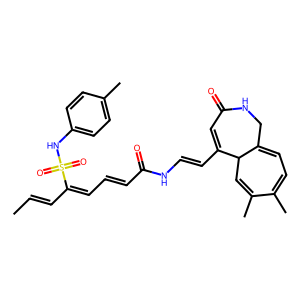


181 : C=1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=CC=C2)C(C3)=CC=O)C=C3C=C=1


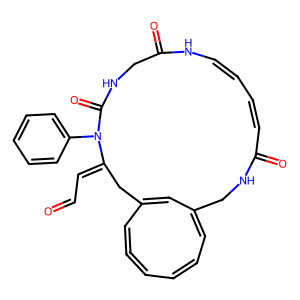


182 : CC=CC1=C(CC(=O)NCCCC(=O)N2CCC(C(=O)N3CCC(C4=CC=C(F)C=C4)CC3)C2)C=C1


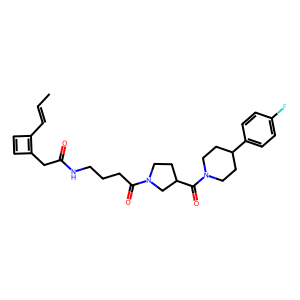


183 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(C)=C3C2=O)OC1C


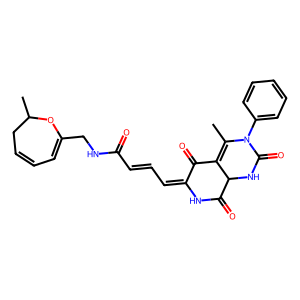


184 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=CC=C2)C(C3)=CC=O)C=C3C1C


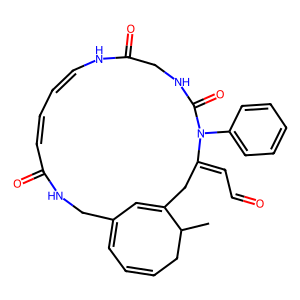


185 : CC1=CC=C(C2NC(=O)C=C3C=C(NC(=O)CNC(=O)C4=CC=C(C(F)(F)F)C=C4C)C3CC)C2C#C1


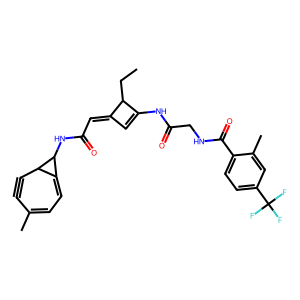


186 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)C(C3)=C13


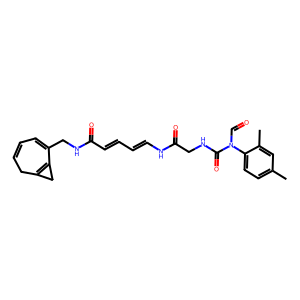


187 : C12C=CC=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)NC=C2C


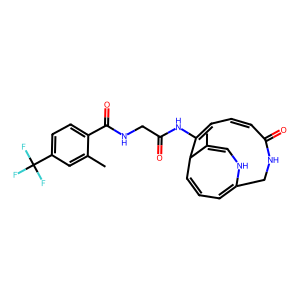


188 : C1C=CC=C(C2C(=O)NCCCC(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C)C=C21


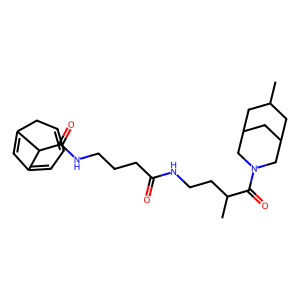


189 : C1C=CC=C(CN2C(=O)C=CC=C(NC(=O)CN3C(=O)C4=CC=C(C(F)(F)F)C=C4C3)OC=C2)C=C1C


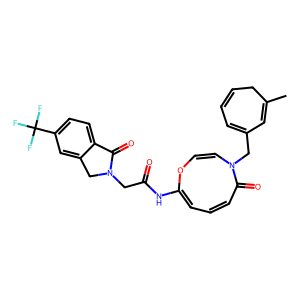


190 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)CN2C(=O)N(C3=CC=CC=C3)C(C)=C(C)C2=O)OC#C1


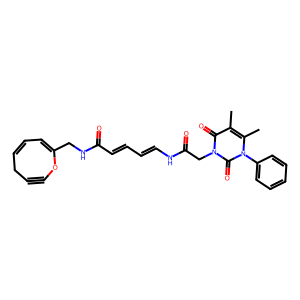


191 : C12C=CC=C(CC(=O)N3CCCCC(=O)NCCC1(C(=O)N4CCC(C)(C)CC4CCC)C3)OC=C2C


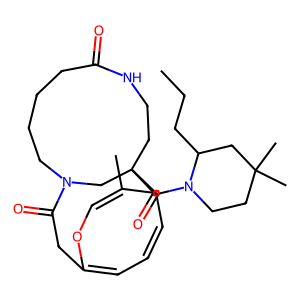


192 : C1C=C2C=C(C(=O)NCCCC(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C)C=C21


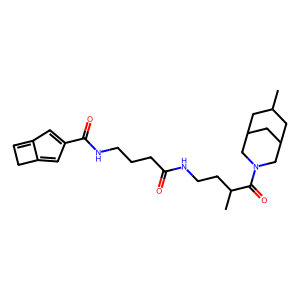


193 : C1C=CC=C(CC(=O)N2CCC(C(=O)NCCCC(C(=O)NC3=CC=C(C)C(C)=C3)C)CC2)OC=C1C


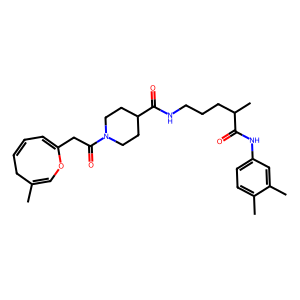


194 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)C(C)=C1


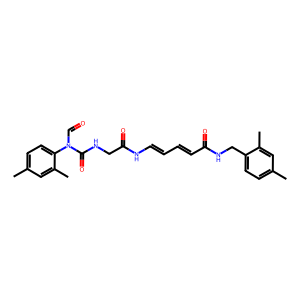


195 : CC=C1C=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)C=C1O


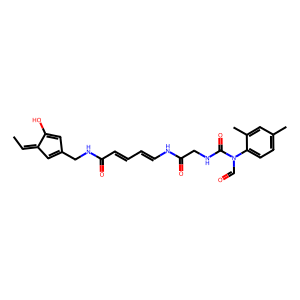


196 : CC=C1C=C(C(=O)NCCCC(=O)N2CCC(C(=O)NCCC(C3=CC=C(C)C=C3C)C)C2)C=C1OC


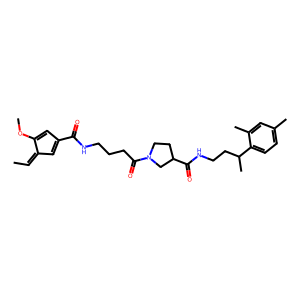


197 : CC=CC1=C(C(=O)NCCCC(=O)N2CCC(C(=O)NC3CCC(C4=CC=C(F)C=C4)CC3)C2)C=C1


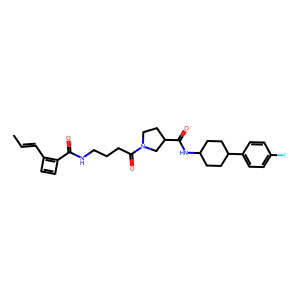


198 : CC1=CC=C(CC(=O)NCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C=CC=C1


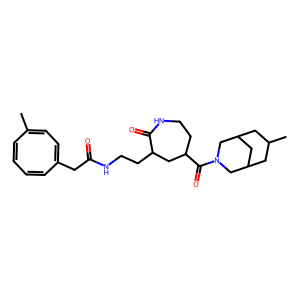


199 : CC=C1C=C(C=NN=C(C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)C2)CC)C1OC


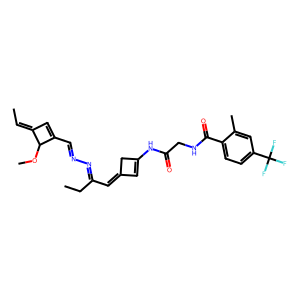


200 : C12C=CC=C(C(=O)NCCC1C(=O)NCCC(C(=O)NC3=CC=C(C(F)(F)F)C=C3)CC)OC#C2


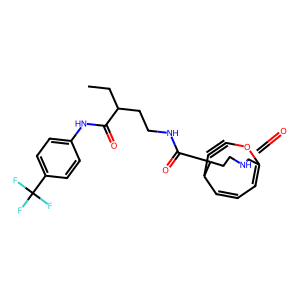


201 : C1C=CC=C(C(=O)NCC2CC(=O)NCCC(C(=O)N3CCC(C4=CC=C(OC)C=C4)CC3)C2)C=C1C


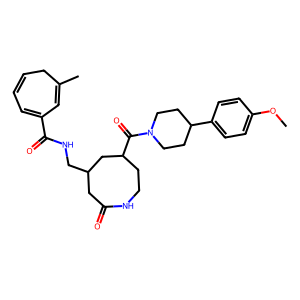


202 : C1C=CC=C1CC(=O)NCCC(C(=O)N2CCC(C(=O)N3CCCC(CC4=CC=CC=C4)C3)C2)C


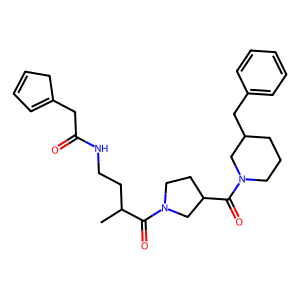


203 : CC=CC1=C(CC(=O)NCCC(C(=O)NCCCCC(=O)NC2=CC=C([N+1](=O)[O-1])C=C2)CCCC)C1


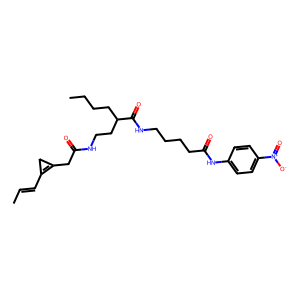


204 : CC=CC1=C(CNC(=O)C=CC=CNC(=O)C=CC=C(S(=O)(=O)NC2=CC=C(C)C=C2)C=C)C#C1


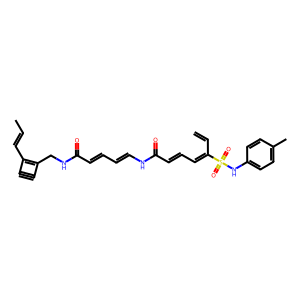


205 : C1C=CC=C(C=NN=C(NC(=O)C2CCCNC(=O)C3=CC=C(S(=O)(=O)N(C)C)C=C3)C2C)C1


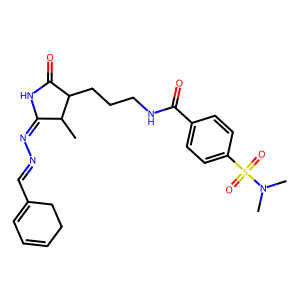


206 : C1C=CC=C(C(=O)N2CCNC(=O)C=CC=C2NC(=O)C=CC=C(C(F)(F)F)C=C)C(=O)OC#C1


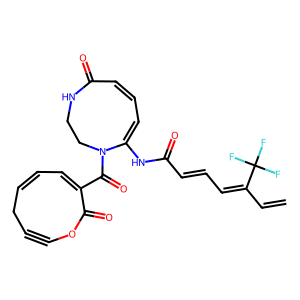


207 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C2=CC=C(C)C=C2C)C=O)CC=C1


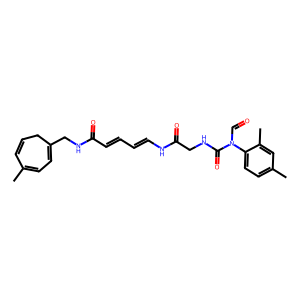


208 : C1C=CC=C(C2C(=O)NCCCC(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C)C=C2C1


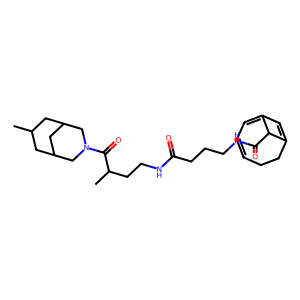


209 : C1C=CC=C1CC(=O)NCCCCC(=O)N2CCC(C(=O)N3CCC(CC4=CC=CC=C4)CC3)C2C


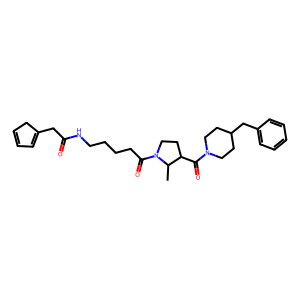


210 : C1C=CC=C(CNC(=O)C=CC=C2NC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC1C


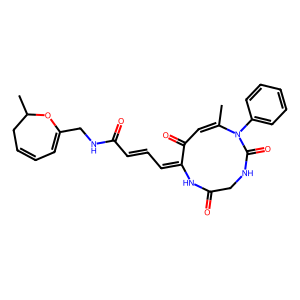


211 : CC=CC=C(C12NC(=O)C=CC=C(NC(=O)CNC(=O)C3=CC=C(S(=O)(=O)N4CCCCCC4)C)C3)C=C1C2


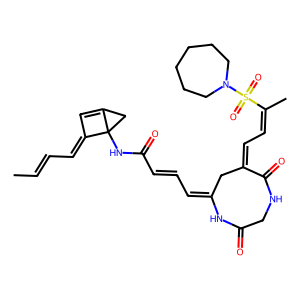


212 : CC1=CC=C(C2NC(=O)C=CC=C2NC(=O)C3NC(=O)N(C4=CC=CC=C4)C(=O)C3=O)CC=C1OC


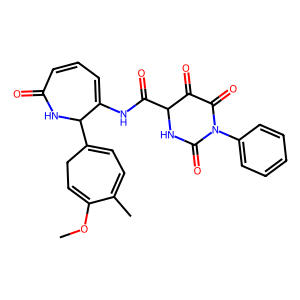


213 : C12C=CC3=C(C=NN=C(NC(=O)C=CC=C1NC(=O)C4=CC=C(C(F)(F)F)C=C4C=C)CC)C3O2


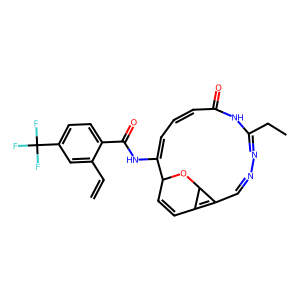


214 : C1C=CC=C(CC(=O)N2CCC(C(=O)NCCCC(C(=O)NC3=CC=C(C)C(C)=C3)C)CC2)OC#C1


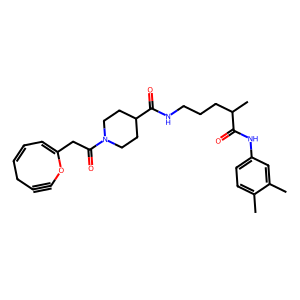


215 : C1C=CC=C(C(=O)N2CCNC(=O)C=CC=C2NC(=O)C=CC=C(C(F)(F)F)C=C)CC=C1C


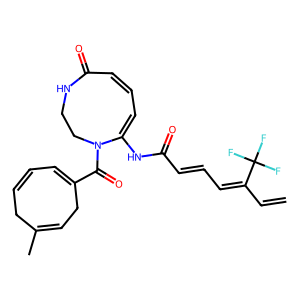


216 : CC1=CC=C(CC2NC(=O)C=C3C=C(NC(=O)CNC(=O)C4=CC=C(C(F)(F)F)C=C4C)C3CC)C2O1


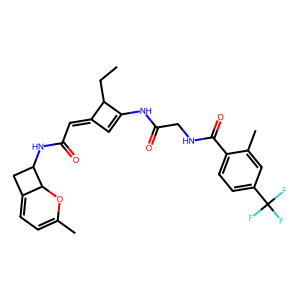


217 : C12C3=CC4=C(C=NN=C(NC(=O)C=CC=C1NC(=O)C5=CC=C(C(F)(F)F)C=C5C=C)C)C=C4C=C23


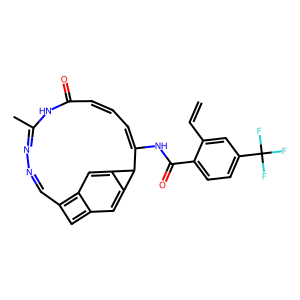


218 : CC=C1C=C(C(=O)NCCCC(=O)NCCC(C(=O)N2CCC(C3=CC=C(F)C=C3)CC2)C)C#C1


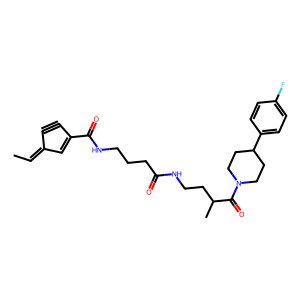


219 : C1C=CC=C1CC(=O)NCCCC(=O)N2CCC(C(=O)N3CCC(CC4=CC=CC=C4)CC3)C2C


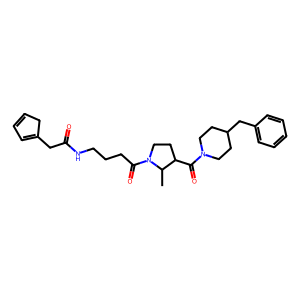


220 : C1C=CC2=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2S1


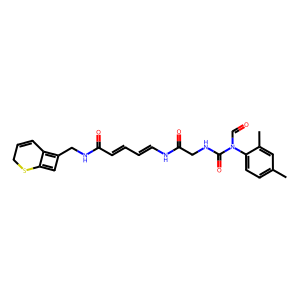


221 : C1C2=CC3=C(CC(=O)NCCC1C(=O)NCCC(C(=O)N4CCC(C5=CC=C(F)C=C5)CC4)C)CC=C23


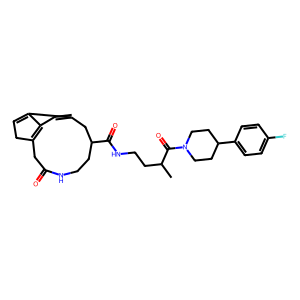


222 : CC=C1C=C(CC(=O)NCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C=C1OC


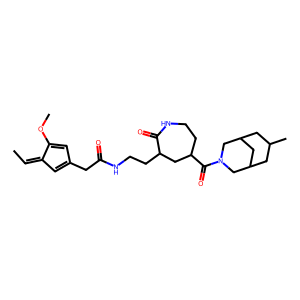


223 : CC=C1C=C(CNC(=O)C(C)N(CC2=CC=C(C)C=C2)C(C)=C(C)N(C3=C4C=C(C)C=C3)C=O)C1C=C4


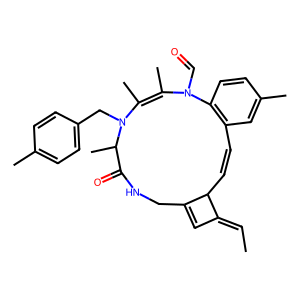


224 : CC=C1C=C(CNC(=O)C=CC2=C(NC(=O)CNC(=O)C3=CC=C(S(=O)(=O)N4CCCC4)C)C3C)C2C=C1C


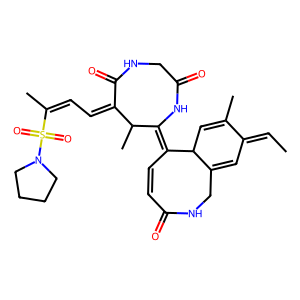


225 : C1C=CC=C(C(=O)N2CCNC(=O)C=CC=C2NC(=O)C=CC=C(C(F)(F)F)C=C)CC=C1


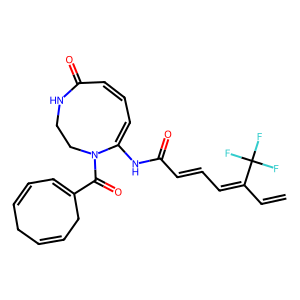


226 : C1C=CC=C(C2NC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2C=C1C


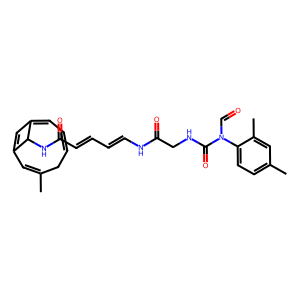


227 : C1C=CC2=C(CNC(=O)C=CC=C1NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N3CCCCC3)C=C)C=CC#C2


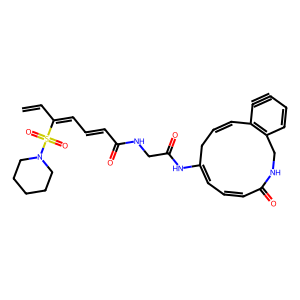


228 : CC=C1C=C(CCN2C(=O)C=C3C=C(NC(=O)C4CCCN(C(=O)C5=CC=CO5)C4)OC=C3C=C2)C(=O)N1


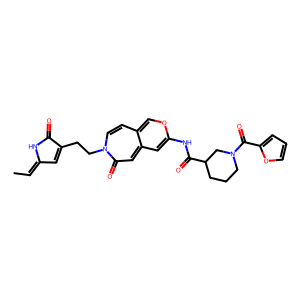


229 : CC=CC1=C(C2NC(=O)C=CC=C(NC(=O)CNC(=O)C3=CC=C(S(=O)(=O)N4CCCCCC4)C)C3)C=C2C1C


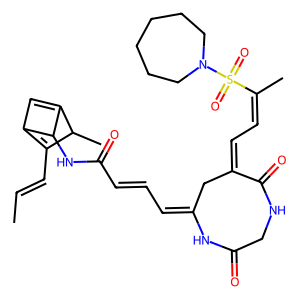


230 : C1C=CC=C1CNC(=O)C=CC=C(NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N2CCCC2C)C)C=C


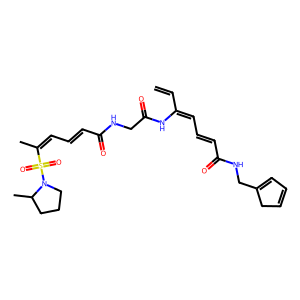


231 : CC=CC1=C(CN2C(=O)C=CC=C(NC(=O)CN3C(=O)C4=CC=C(C(F)(F)F)C=C4C3)OC=C2)C=C1O


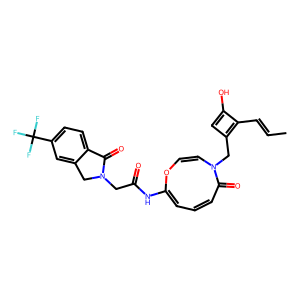


232 : CC=C1C=C(CC(=O)NCCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C=C1


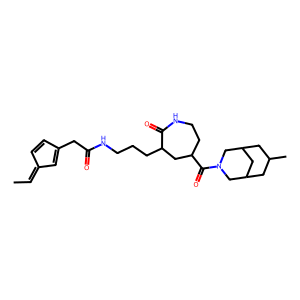


233 : CC=CC1=C(CNC(=O)C=CC=C2NC(=O)C=CC=C(S(=O)(=O)N3CCCC(C)C3)C=CC=C2)C=C1OC


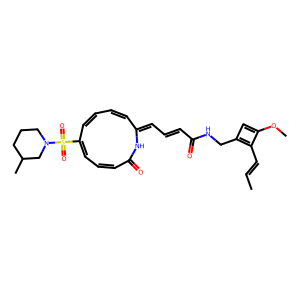


234 : CC1=CC2=C(CNC(=O)C=CC=CNC(=O)C=CC=C2S(=O)(=O)NC3CCCCC3C=C)C=C1O


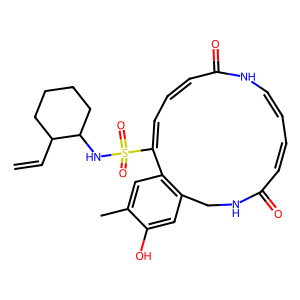


235 : CC=CC1=C(CNC(=O)C=C2C=CNC(=O)CNC(=O)N(C3=C4C=CC=C3)C5=CC=CC=C5C4=C2)C=CC=C1C


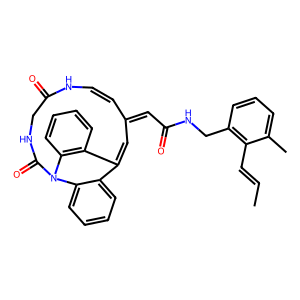


236 : C1C=CC=C(CNC(=O)C2=CC=CNC(=O)CNC(=O)N(C3=CC=CC=C3)C(C)=CC2=O)OC#C1


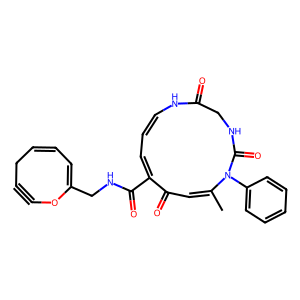


237 : C1C=CC=C1CCNC(=O)C=CC=C(NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N2CCCC2C)C)C=C


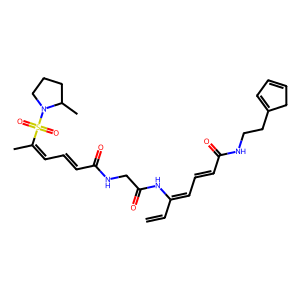


238 : CC=CC1=C(CNC(=O)C2=CC=C(NC(=O)C3NC(=O)N(C4=CC=CC=C4)C5=CC=CC=C53)C2=O)C=C1


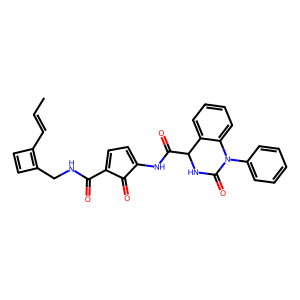


239 : CC=CC=C(CC(=O)N1CCCC(=O)NCCC(C(=O)N2CC3CC(CC(C3)C2)C)C)C1=O


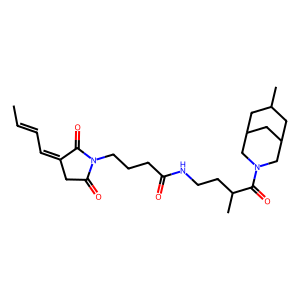


240 : C1C=CC=C(CNC(=O)C=CC=CNC(=O)C23NC(=O)N(C4=CC=CC=C4)C(=O)C2C3=O)C=CC#C1


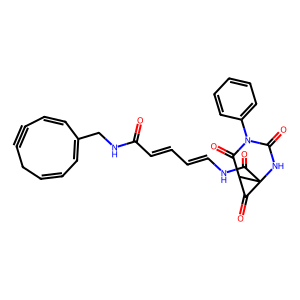


241 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)CN2C(=O)N(C)C(C)=C(C)C(C)=C2C=O)OC=C1C


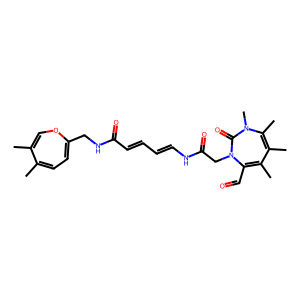


242 : C1C=CC=C(CN2C(=O)C=CC=C(NC(=O)CN3C(=O)C4=CC=C(C(F)(F)F)C=C4C3)OC=C2)C#C1


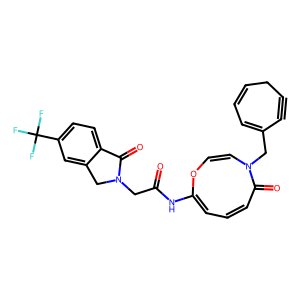


243 : CC=C1C=C(CNC(=O)C=CC2=CNC(=O)C=CC=C(S(=O)(=O)NC3=CC=C(C)C=C3)C=C2)C=C1


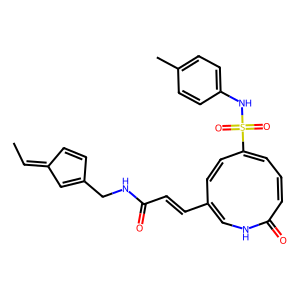


244 : C1C2=CC=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C21


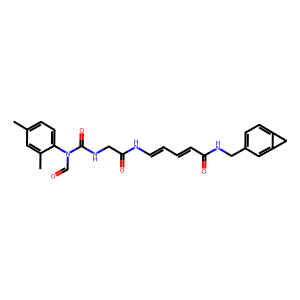


245 : CC1=CC=C(C(=O)NCCC2C(=O)NCCC(C(=O)NC3CCC(C(=O)N4CCCCC4)CC3)C2)C=C1C


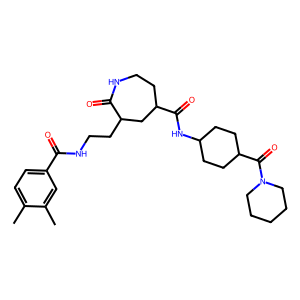


246 : CC=CC1=C(C=NN=C(NC(=O)CCC2CNC(=O)C3=CC=C(C(F)(F)F)C=C3C=C2)CC)OC=C1OC


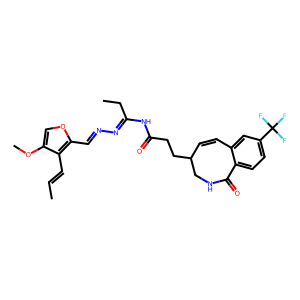


247 : CC1=CC=C(CNC(=O)C=CC=CNC(=O)C2NC(=O)N(C3=CC=CC=C3)C(=O)C2=O)CC=C1OC=C


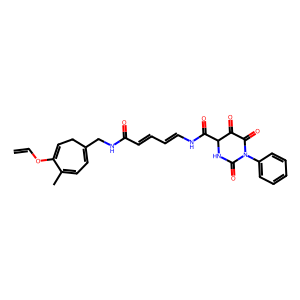


248 : CC=C1C=C(CC(=O)NCCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C#C1


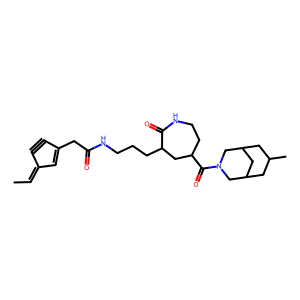


249 : CC=C1C=C(C2CCCCN2C(=O)C=C3C=CNC(=O)CNC(=O)C4=CC=C(C(F)(F)F)C=C4C)C3C=C1C


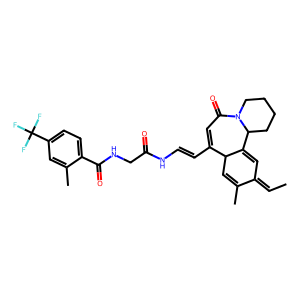


250 : CC=CC1=C(CCNC(=O)C=C2C=C(NC(=O)CNC(=O)C3=CC=C(C(F)(F)F)C=C3C)C2CC)C1OC


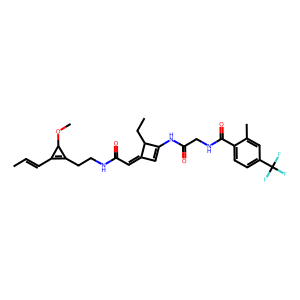


251 : CC1=CC=C(C(=O)NCCC2C(=O)NCCC(C(=O)NC3CCC(C(=O)N4CCCCC4)CC3)C2)C#C1


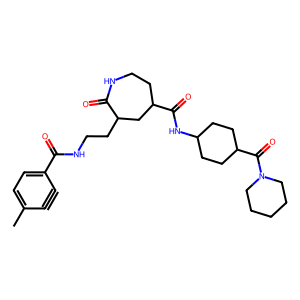


252 : C1C=C2C=C(C=NN=C(NC(=O)C=CC=C1NC(=O)C3=CC=C(C(F)(F)F)C=C3C=C)C=C)C=C2OC


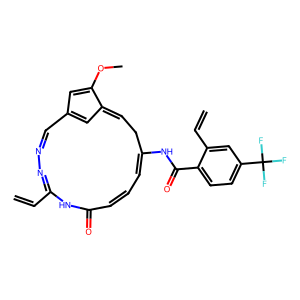


253 : C12C=CC=C(C(=O)NCCC1C(=O)NCCC(C(=O)NC3=CC=C(C(F)(F)F)C=C3)CC)OC=C2C


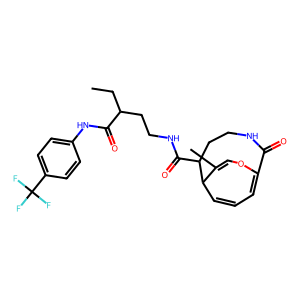


254 : C1C=CC2=C(CC(=O)NCCCC(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C)C=C2O1


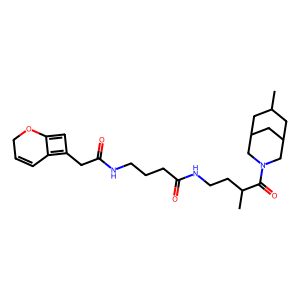


255 : C1C=C2C=C(C3NC(=O)C=CC=C1NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N4CCCCC4)C=C)C3C#C2


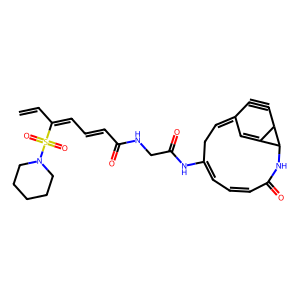


256 : CC=CC1=C(CNC(=O)C=CC=C2NC(=O)C=CC=C(S(=O)(=O)N3CCCC(C)C3)C=CC=C2)C=C1C


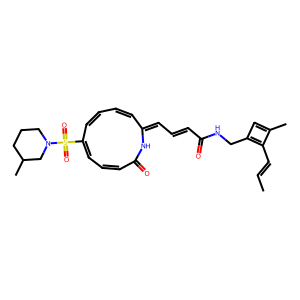


257 : C1C=C2C=C(CNC(=O)C=CC3=C1NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N4CCCCC4)C=C)C3C#C2


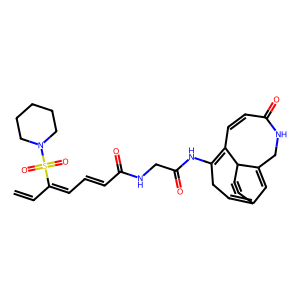


258 : C1C=CC=C(CNC(=O)C(C)N(CC2=CC=C(C)C=C2)C(C)=C(C)N(C3=CC=C(C)C=C3)C=O)C#C1


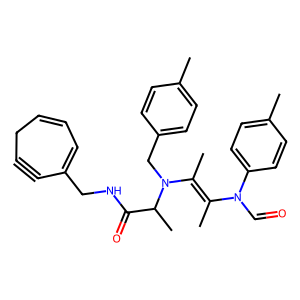


259 : CC=CC=C(CNC(=O)C=CC1=CNC(=O)CNC(=O)N(C2=C3C=CC=C2)C4=CC=CC=C4C3=C1)C=C=O


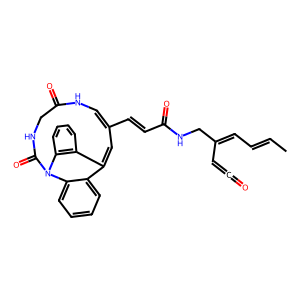


260 : C1C=C2C=C(CNC(=O)C=CC3=C1NC(=O)CNC(=O)C=CC=C(S(=O)(=O)N4CCCCC4)C=C)C3C=C2C


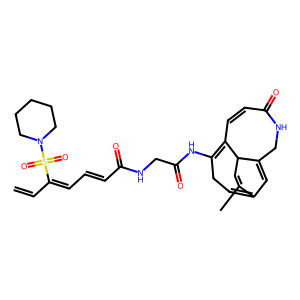


261 : C1C=C2C=C(CNC(=O)C=CC=CNC(=O)CNC(=O)N(C3=CC=C(C)C=C3C)C=O)C=C2C=C1C


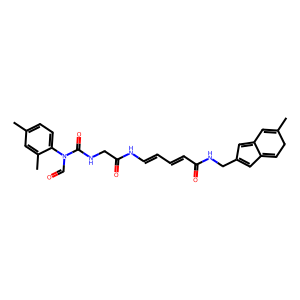


262 : C1C=CC=C(CC(=O)NCCC2C(=O)NCCC(C(=O)N3CC4CC(CC(C4)C3)C)C2)C=C1OC


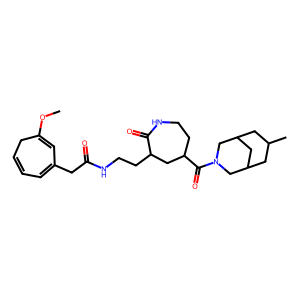


263 : C1C=CC=C(CCCCC2NC(=O)CC3CCN(C(=O)C4=CC=C(C(F)(F)F)C=C4CC)N3)C2C=C1C


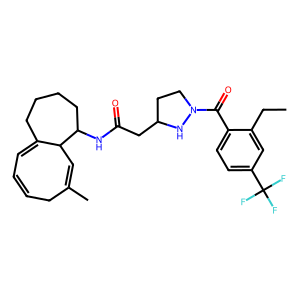


264 : C1C=CC=C(C=NN=C(NC(=O)C2CCCNC(=O)C3=CC=C(S(=O)(=O)N(C)C)C=C3)C2C)CC=C1C


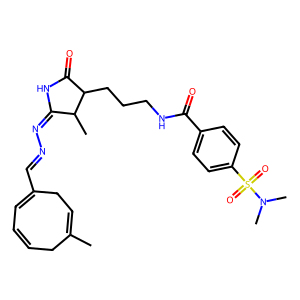

In [ ]:
print(f'dutasteride : {dutasteride}')
display(Chem.MolFromSmiles(dutasteride))

for i, smiles in enumerate(gen_mols) :
    print(f'\n{i} : {smiles}')
    img = Draw.MolToImage(Chem.MolFromSmiles(smiles))
    display(img)

In [ ]:
wandb.finish()

epoch,100
epoch_train_loss,0.66823
epoch_val_loss,0.62201
test_loss,0.61201


# load trial

In [ ]:
trial.wandb_load_run('t9z44fwe')
trial.load_model('rossi22/TRANS_VAE_SELFIES_TRAIN/TRANS_VAE_SELFIES_TRAIN_best_model_230822.pth:v0', from_wandb=True)
test_loss = trial.test(val_loader)
test_loss

wandb:   1 of 1 files downloaded.  


array(0.6107663, dtype=float32)

In [ ]:
wandb.finish()

epoch,100
epoch_train_loss,0.66823
epoch_val_loss,0.62201
test_loss,0.61077
